# ID5059 P2 Group Project

## Imports

Import relevant packages.

In [ ]:
# reminder of which packages to install:
# pip install numpy pandas matplotlib scikit-learn seaborn imblearn xgboost optuna

# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random

# sklearn imports
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    log_loss,
    mean_squared_error,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# imblearn imports
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imblearnPipeline

# Other libraries
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")  # Ignore warnings

## Read in the data

Here we read in the information from the given CSV files. We drop the ID column as it's duplicated by pandas, and we also make a copy of the training data in order to test out some imputation methods on it. We separate out the independent variables from the response variable for this copy to obtain X_copy and Y_copy.

In [10]:
# read the data, dropping the ID column, as this is duplicated by pandas
raw_training_data = pd.read_csv(r"train.csv").drop(columns=["id"])
raw_test_data = pd.read_csv(r"test.csv").drop(columns=["id"])

# copy the raw training data
copy_raw_training_data = raw_training_data.copy()

# separate out the independent variables from the target
X_copy = copy_raw_training_data.drop(labels=['Status'], axis=1)
Y_copy = copy_raw_training_data["Status"]

## Data Analysis & Exploration

The main two ways we can understand our data is through both numerical and graphical analysis. The former allows us to quantify features of the data and the latter gives a more visual representation of our findings, which makes the information clearer and easier to understand.

### Numerical Analysis

We first look at how many data points we have as well as the number of attributes.

In [11]:
print(f"Train set shape: {raw_training_data.shape}") 
# print(f"Test set shape: {raw_test_data.shape}") # doesn't have the 'Status' column
# print()

Train set shape: (7905, 19)


This is plenty of data to train a model on, and since we only have 19 attributes we need not perform feature selection.

Now we want to see how many missing values each column has.

In [12]:
print(f"Null count for both data sets:")
print(pd.concat([raw_training_data.isnull().sum().astype(float), raw_test_data.isnull().sum().astype(int)], axis=1).rename(columns={0: 'Train Set', 1: 'Test Set'}))

Null count for both data sets:
               Train Set  Test Set
N_Days               0.0       0.0
Drug                 0.0       0.0
Age                  0.0       0.0
Sex                  0.0       0.0
Ascites              0.0       0.0
Hepatomegaly         0.0       0.0
Spiders              0.0       0.0
Edema                0.0       0.0
Bilirubin            0.0       0.0
Cholesterol          0.0       0.0
Albumin              0.0       0.0
Copper               0.0       0.0
Alk_Phos             0.0       0.0
SGOT                 0.0       0.0
Tryglicerides        0.0       0.0
Platelets            0.0       0.0
Prothrombin          0.0       0.0
Stage                0.0       0.0
Status               0.0       NaN


Since there are no missing values, we will have to delete data manually in order to assess different imputation methods. We made a copy of the original training data in order to remove values and not affect the data we have.

We now analyse the numerical features of the data. The function desctibe gives a summary of key information such as mean and standard deviation.

In [13]:
print("Summary of numerical features:")
print(raw_training_data.describe().round(3))

Summary of numerical features:
         N_Days        Age  Bilirubin  Cholesterol   Albumin    Copper  \
count  7905.000   7905.000   7905.000     7905.000  7905.000  7905.000   
mean   2030.173  18373.146      2.594      350.562     3.548    83.903   
std    1094.234   3679.959      3.813      195.379     0.346    75.899   
min      41.000   9598.000      0.300      120.000     1.960     4.000   
25%    1230.000  15574.000      0.700      248.000     3.350    39.000   
50%    1831.000  18713.000      1.100      298.000     3.580    63.000   
75%    2689.000  20684.000      3.000      390.000     3.770   102.000   
max    4795.000  28650.000     28.000     1775.000     4.640   588.000   

        Alk_Phos      SGOT  Tryglicerides  Platelets  Prothrombin     Stage  
count   7905.000  7905.000        7905.00   7905.000     7905.000  7905.000  
mean    1816.745   114.605         115.34    265.229       10.629     3.033  
std     1903.751    48.791          52.53     87.466        0.782   

Some of these features have vastly different distributions, and so in order to feed them into a machine learning model we will have to standardise them in some way.

Then we take a look at how many unique values each attribute has.

In [14]:
print(pd.concat([raw_training_data.nunique().rename('Unique count'), raw_training_data.dtypes.rename('Data type'), ], axis=1))

               Unique count Data type
N_Days                  461     int64
Drug                      2    object
Age                     391     int64
Sex                       2    object
Ascites                   2    object
Hepatomegaly              2    object
Spiders                   2    object
Edema                     3    object
Bilirubin               111   float64
Cholesterol             226   float64
Albumin                 160   float64
Copper                  171   float64
Alk_Phos                364   float64
SGOT                    206   float64
Tryglicerides           154   float64
Platelets               227   float64
Prothrombin              49   float64
Stage                     4   float64
Status                    3    object


Unsuprisingly, the numerical columns have many unique values. However it's helpful that the categorical columns all have very few unique values. This means that if we were to one-hot encode the data later on, we wouldn't create too many new columns. In particular, the attribues with only 2 unique values can be encoded with binary values.

We also want to have a look at how many instances we have of each response variable.

In [15]:
print("Proportion of each response variable:")
print(raw_training_data['Status'].value_counts() / np.shape(raw_training_data)[0])

Proportion of each response variable:
C     0.628083
D     0.337128
CL    0.034788
Name: Status, dtype: float64


This is slightly concerning to see. Since there is a severe unbalance of the response variables, we will need to account for this using various sampling methods. If we were to ignore this, our model would severely underfit on the CL category since there are so few instances with that response. It would also likely overfit on the C category since there are so many of them. As long as we use sampling methods we should be able to account for this.

### Graphical Analysis

We can now take the information we have found during our initial analysis and represent it with graphs. This will allow us to easily discern relationships between variables and also individual variable distributions.

First we take a look at a correlation matrix between the numerical attributes within the data.

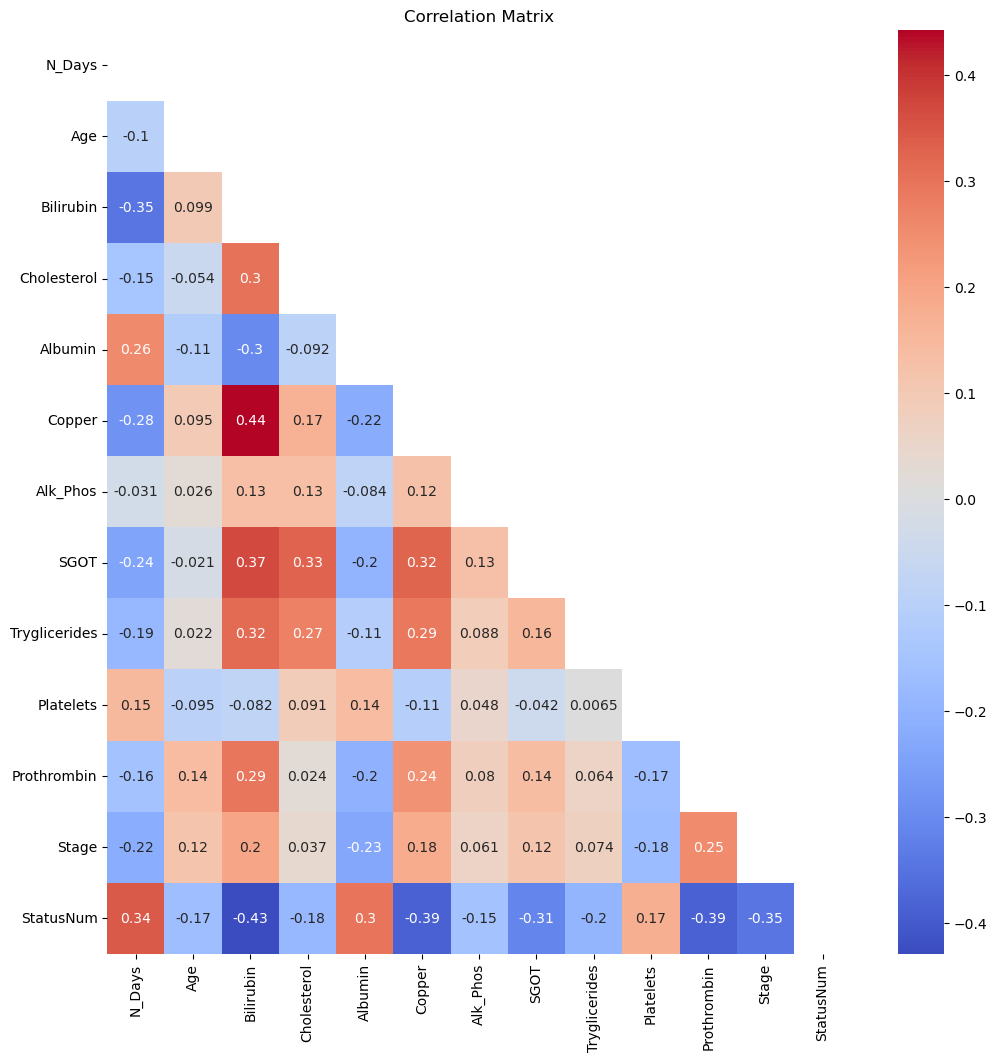

In [16]:
# convert Status response to numerical for correlation exploration
response_map = {'D':0, 'CL':1, 'C':2}
raw_training_data['StatusNum'] = raw_training_data['Status'].map(response_map)

matrix = raw_training_data[raw_training_data.select_dtypes(include=['int64', 'float64']).columns].corr() # define correlation matrix
raw_training_data = raw_training_data.drop(columns=['StatusNum']) # drop the numerical Status label
diagmask = np.triu(np.ones_like(matrix)) # create mask to only map lower diagonal
plt.figure(figsize=(12, 12)) # create figure
sns.heatmap(matrix, annot=True, cmap='coolwarm', mask=diagmask) # plot the heatmap
plt.title('Correlation Matrix')
plt.show()

None of the features have too strong of a correlation with each other; the strongest positive correlation is between Copper and Bilirubin being 0.44, and the strongest negative correlation being N_Days and Bilirubin with -0.35. This means that we don't have to worry about deleting any columns in order to avoid using diplicate data. It also shows that Bilirubin may be an important variable in the model since it seems to either influence or be influenced by other variables relatively strongly. Also, the response variable 'Status' has been converted to a numerical variable 'StatusNum' for this correlation matrix to compare the correlation between the features and the response variable 'Status'. The strongest correlation between a feature and the response variable is the correlation between 'Bilirubin' and 'StatusNum' with a correlation of -0.43.

We now take a look at histrograms showing the distributions of all the numerical attributes. This can show us how each column is spread and hence help us make a decision on whether to standardise or normalise the data during the pipelining process.

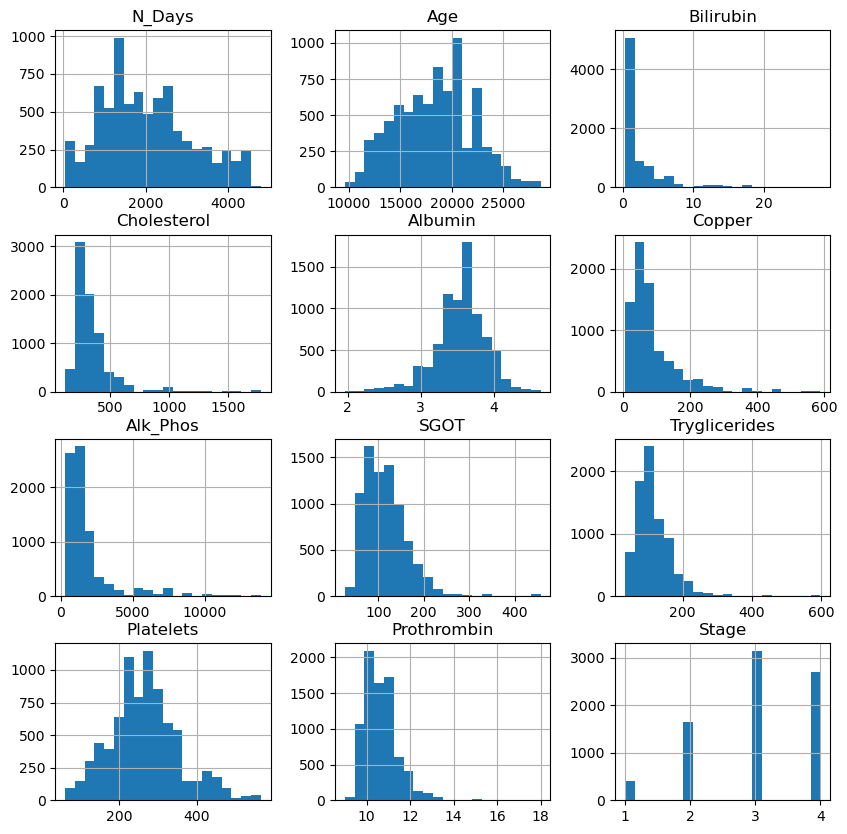

In [17]:
# plot histograms for numerical variables
raw_training_data.hist(bins=20, figsize=(10, 10))
plt.show()

These attributes mostly have normally distributed data, with some of them having outliers such as Bilirubin, Copper and Alk_Phos. This indicates that normalisation would be a poor choice of transformation for our dataset, since it handles outliers poorly. Hence we will use standardisation instead. We can now look in more detail at the outliers of some of these variables.

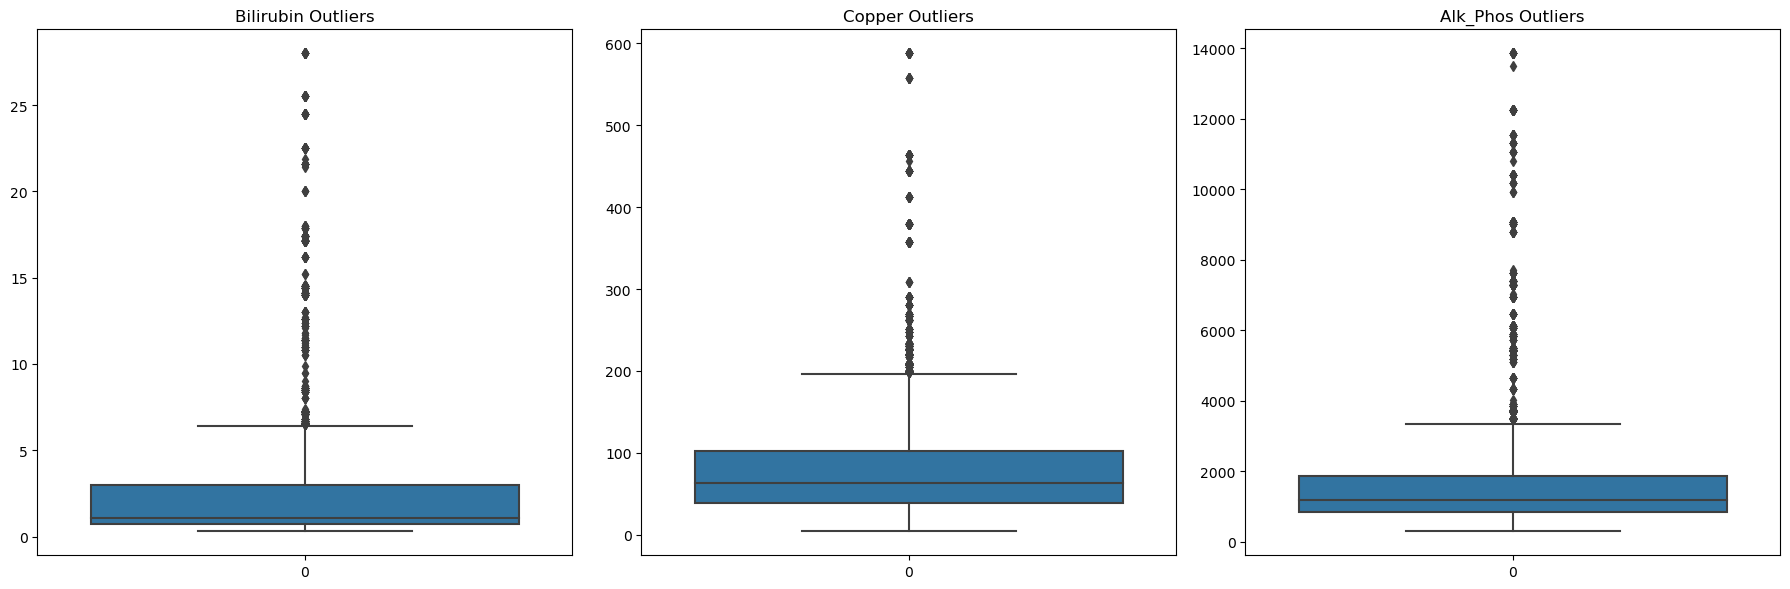

In [18]:
# Outlier Detection for 'Bilirubin', 'Copper', and 'Alk_Phos'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.boxplot(ax=axes[0], data=raw_training_data['Bilirubin'], orient="v")
sns.boxplot(ax=axes[1], data=raw_training_data['Copper'], orient="v")
sns.boxplot(ax=axes[2], data=raw_training_data['Alk_Phos'], orient="v")
axes[0].set_title('Bilirubin Outliers')
axes[1].set_title('Copper Outliers')
axes[2].set_title('Alk_Phos Outliers')
plt.tight_layout()
plt.show()

It is now clear to see that all three of these attributes have a large amount of outliers, represented by the large quantity of dots above the horizontal lines on each plot.

We now want to have a look at each categorical variable, and how much of each respone they have.

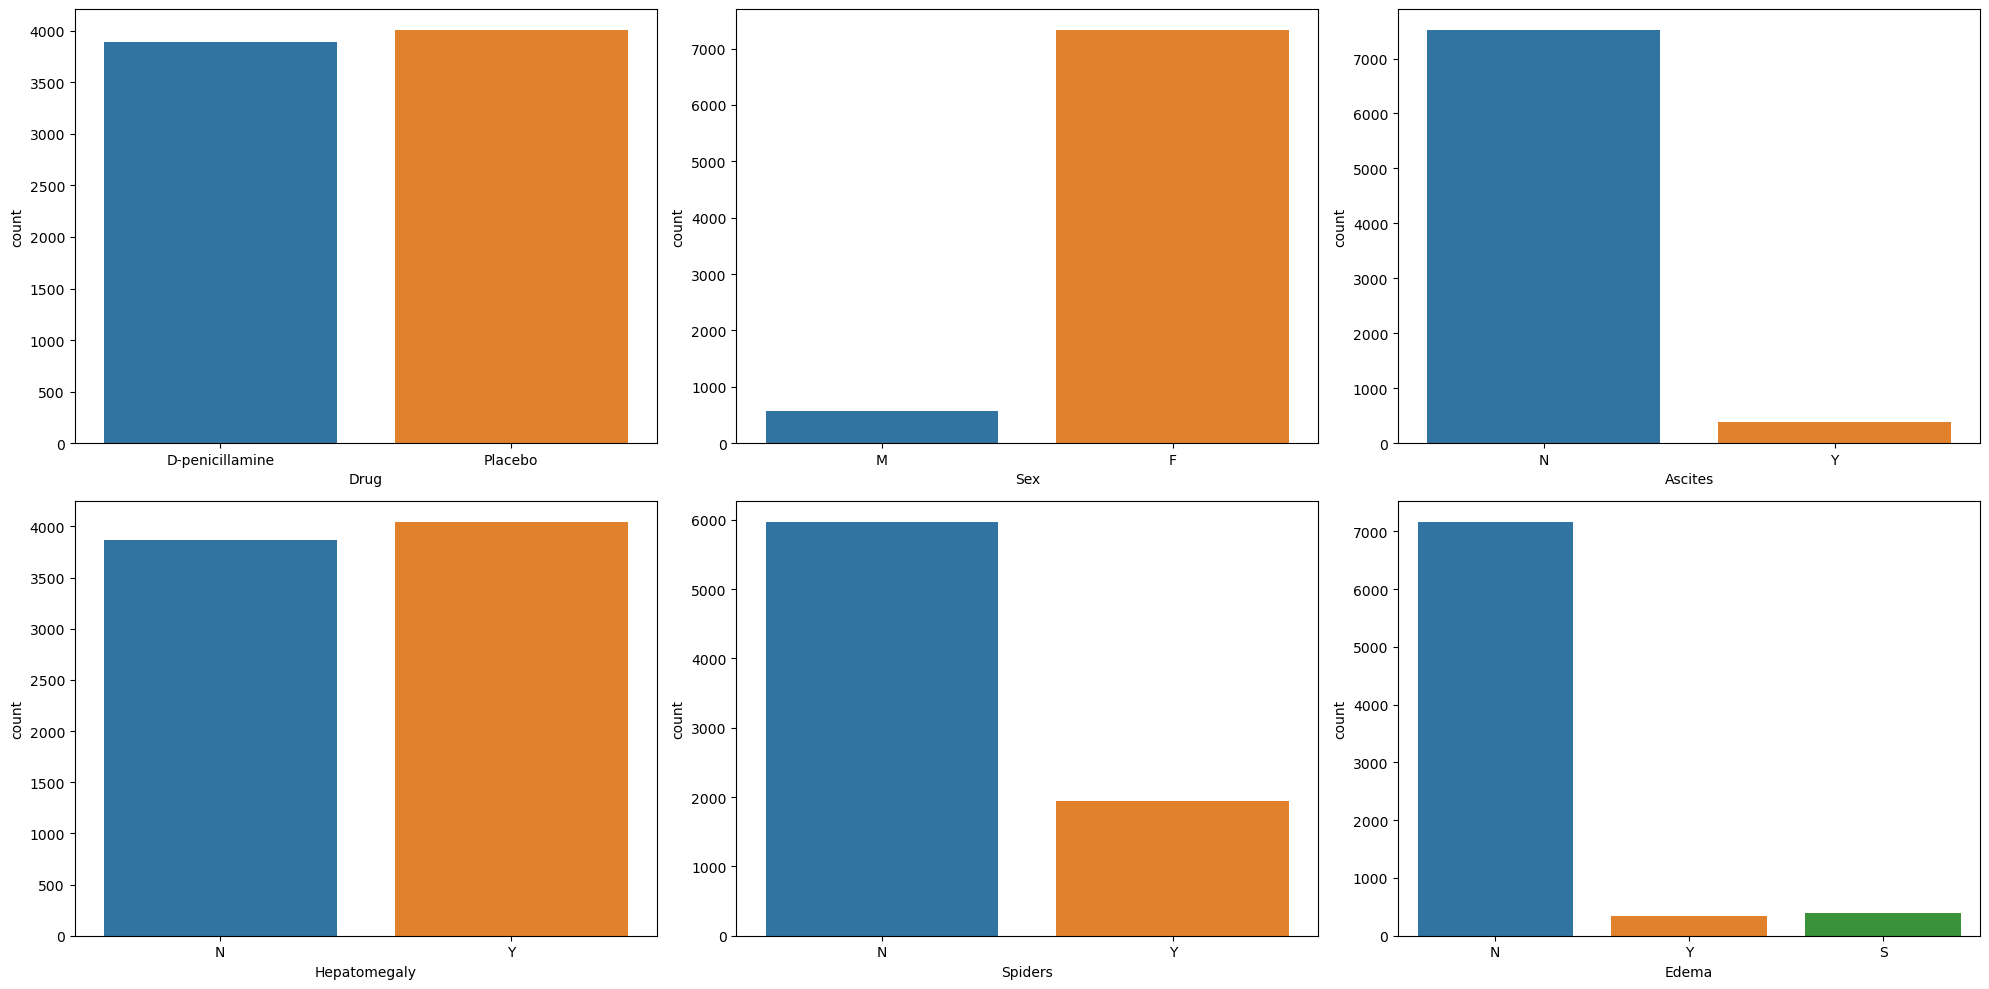

In [19]:
# Categorical Features Distribution
categorical_features = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axes = axes.flatten()
for i, cat_feature in enumerate(categorical_features):
    sns.countplot(x=cat_feature, data=raw_training_data, ax=axes[i])
plt.tight_layout()
plt.show()

Some of these attributes are relatively balanced, such as Drug and Hepatomegaly, and others are less so. The categories with unbalanced data are not a problem for our model, in fact they may be helpful since it is possible that if a patient has one of the uncommon categories they could be more at risk from the disease. Hence these categories may be helpful for the final model.

We can also have a look at the distribution of different response variables graphically.

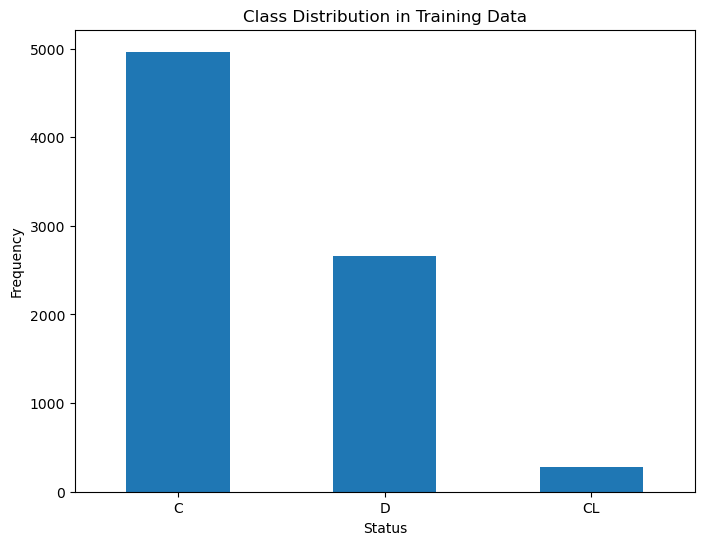

In [20]:
plt.figure(figsize=(8, 6))                                      # make a figure
raw_training_data['Status'].value_counts().plot(kind='bar')     # plot a bar chart for the status variable
plt.title('Class Distribution in Training Data')                # label the plot and set the size
plt.xlabel('Status')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()                                                      # oputput the plot

It is clear to see that we have very unbalanced amounts of each of these response variables. As indicated before, we certainly have to deal with this using sampling methods later on.

Another key piece of information we can look at is how some features are distributed depending on the class they are in (what the response variable is).

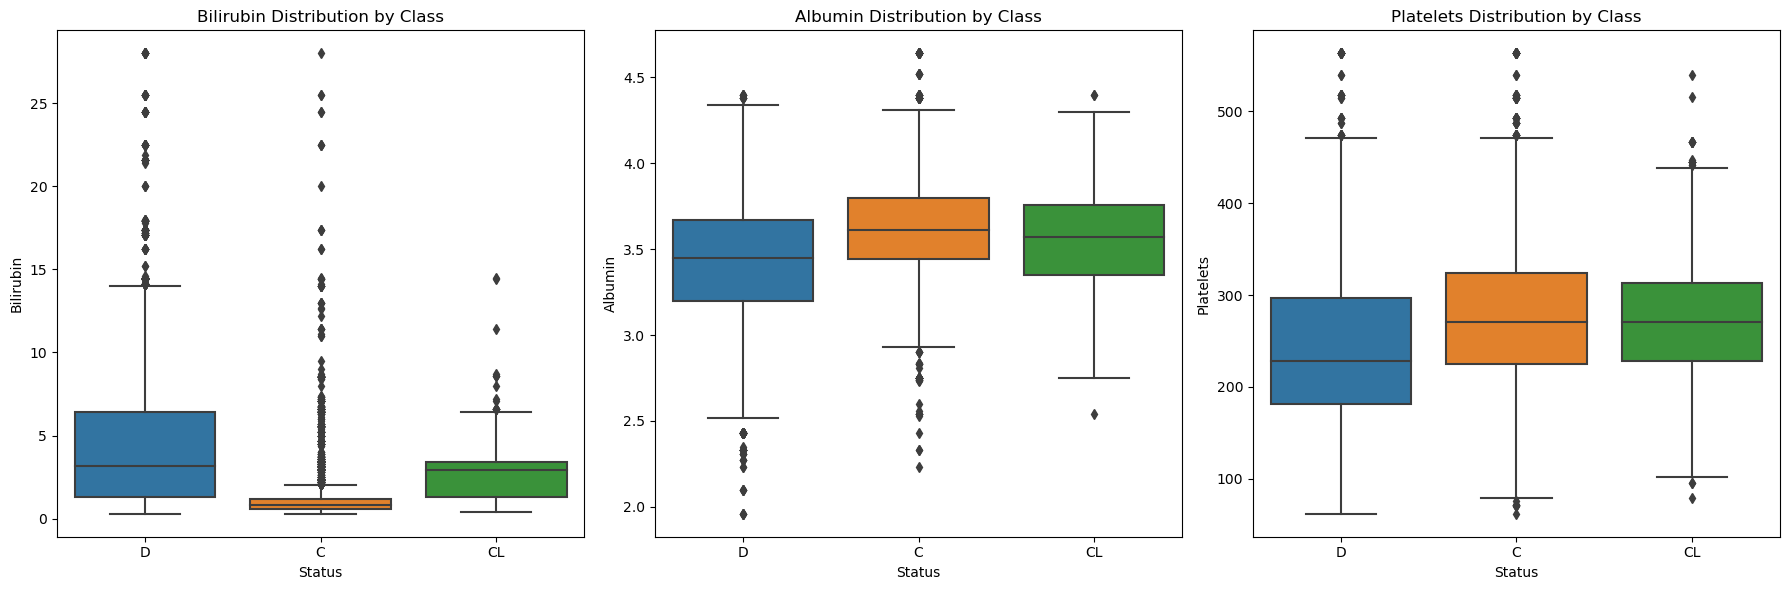

In [21]:
# Feature Distribution by Class for 'Bilirubin', 'Albumin', and 'Platelets'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))                                 # create a plot with subplots
sns.boxplot(ax=axes[0], x='Status', y='Bilirubin', data=raw_training_data)      # make a separate box plot for each of the features, separating out by class
sns.boxplot(ax=axes[1], x='Status', y='Albumin', data=raw_training_data)
sns.boxplot(ax=axes[2], x='Status', y='Platelets', data=raw_training_data)
axes[0].set_title('Bilirubin Distribution by Class')                            # label the plots and output them
axes[1].set_title('Albumin Distribution by Class')
axes[2].set_title('Platelets Distribution by Class')
plt.tight_layout()
plt.show()

Although the distributions by class are very similar for Albumin and Platelets (with a lot of overlap between the boxes), the Bilirubin category tells a different story. All three class distributions are relatively different, with the C distribution having little to no overlap at all with the others. This means that in theory we could obtain a model with relatively high accuracy using Bilirubin alone, and so this attribute will be very important in our model later on.

We can also explore the interaction effects between features, plotting Bilirubin and Albumin against one another and colouring the points depending on their class.

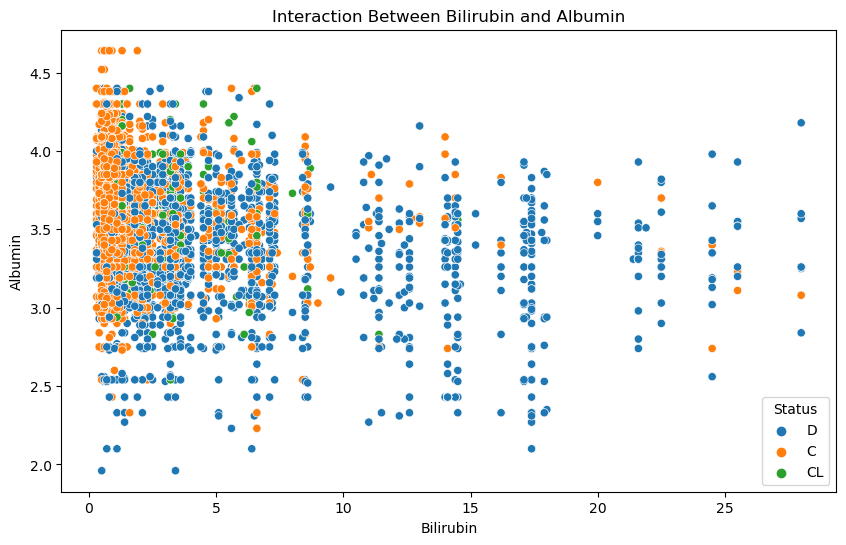

In [22]:
# Interaction Effects Between 'Bilirubin' and 'Albumin'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Bilirubin', y='Albumin', hue='Status', data=raw_training_data)
plt.title('Interaction Between Bilirubin and Albumin')
plt.show()

It is unclear whether there is a strong effect from Albumin, however since many of the points past the 5 or 10 mark on the x-axis are blue, this shows that a high Bilirubin level correlates to a higher change of death.

Another way we can analyse the data is to look at the distribution of some numerical variables across the 3 different classes. Here we see what that looks like for Albumin, Bilirubin and Platelets.

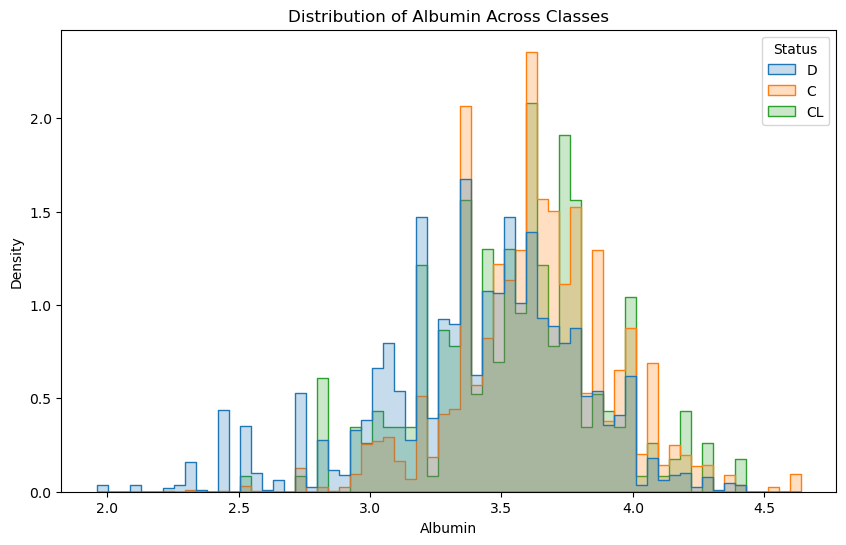

In [23]:
# Distribution of 'Albumin' Across Different 'Status' Values
plt.figure(figsize=(10, 6))
sns.histplot(data=raw_training_data, x='Albumin', hue='Status', element='step', stat='density', common_norm=False)
plt.title('Distribution of Albumin Across Classes')
plt.show()

This plot has a noticeably further right peak of the C and CL categories compared to D. This indicates that higher Albumin levels could correspond to a higher chance of survival. This attribute seems to be important for predicting the outcome for a patient, so it should certainly be included in the model.

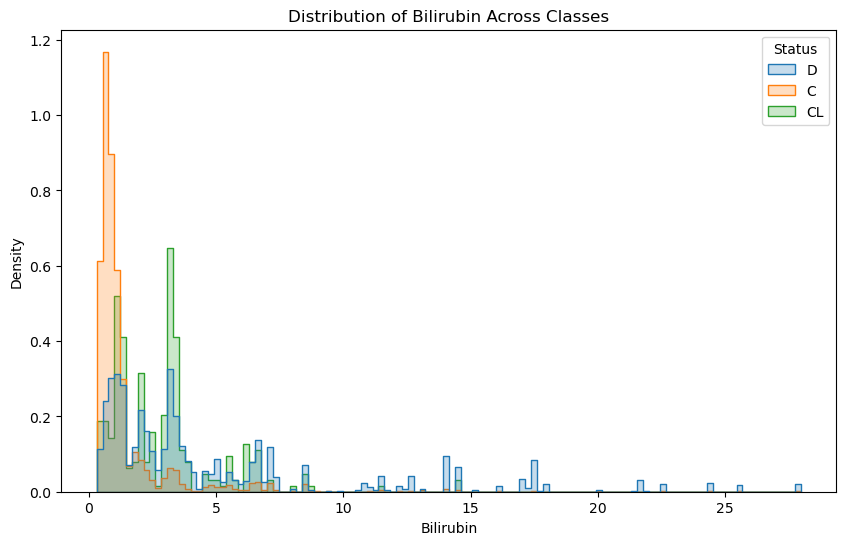

In [24]:
# Distribution of 'Bilirubin' Across Different 'Status' Values
plt.figure(figsize=(10, 6))
sns.histplot(data=raw_training_data, x='Bilirubin', hue='Status', element='step', stat='density', common_norm=False)
plt.title('Distribution of Bilirubin Across Classes')
plt.show()

As was indicated in the plot of the interaction between Bilirubin and Albumin, we can see a higher survival rate for patients with low levels of Bilirubin.

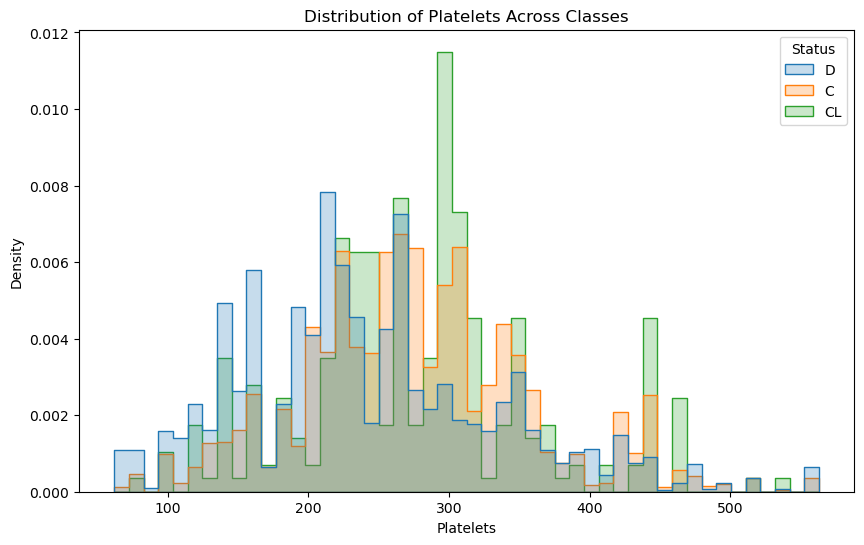

In [25]:
# Distribution of 'Platelets' Across Different 'Status' Values
plt.figure(figsize=(10, 6))
sns.histplot(data=raw_training_data, x='Platelets', hue='Status', element='step', stat='density', common_norm=False)
plt.title('Distribution of Platelets Across Classes')
plt.show()

Similarly to Albumin, this plot has a lower blue peak (class D) than the other 2 categories, indicating a lower survival rate for low Platelet levels.

All three of these variables seem to be important for the model, and we can quantify their performance much more accurately once we have fitted a model.

We can also check that the proportions of the status variable are similar for both the placebo and the given drug.

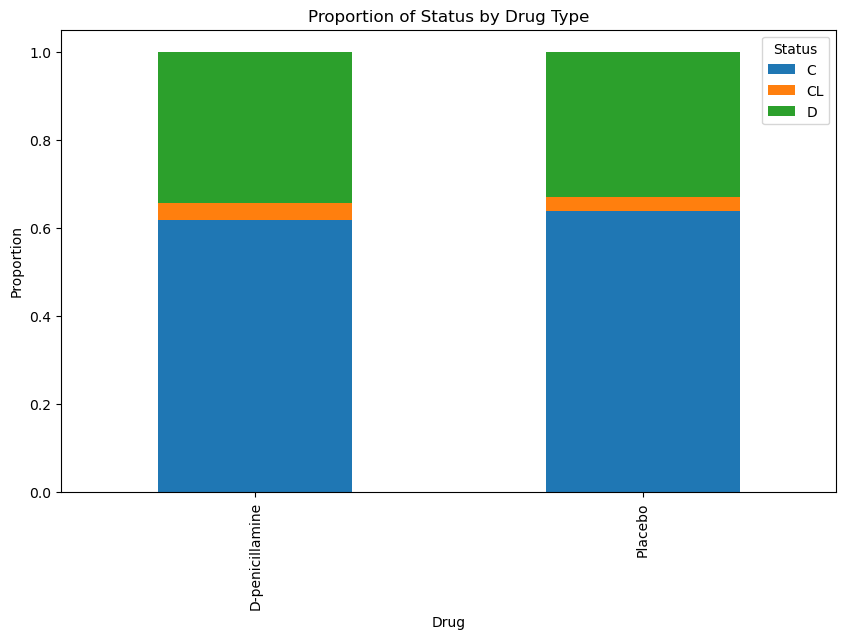

In [26]:
# Stacked Bar Chart for 'Drug' and 'Status'
cross_tab = pd.crosstab(index=raw_training_data['Drug'], columns=raw_training_data['Status'], normalize='index')
cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Proportion of Status by Drug Type')
plt.ylabel('Proportion')
plt.show()

This shows that they are vary similar for both options for the Drug category. This may indicate that the drug had little effect on the outcome of patients, but once again we can conduct a more thorough investigation of feature importance at the end.

### Data Analysis Results

The main things that we have learned from our data analysis and exploration are the following:

* We have a large amount of data, which will be sufficient for training machine learning models

* There are no missing values in the data, so in order to assess imputation methods we must remove data on our own

* The categorical variables have few unique values, so encoding them will be relatively straightforward

* The distribution of response classes is very unbalanced, so we will need to perform sampling methods on our data in order to obtain the best models

* The numerical variables have many outliers, and so we should use standardisation instead of normalisation to transform our data

* Bilirubin seems to be an important variable for predicting the outcome of a patient

## Imputation Methods

We now want to explore different imputation methods and compare how effective they are. Since the data we have been given does not have any missing values, we will have to make a copy of it, remove some entries manually, then use various methods to impute the data back and assess each one.

The two methods we will use to compare imputation methods are the following:
* Calculate the RMSE of imputed numerical values and the accuracy and f1 score of imputed categorical values. Plot these on a graph.
* Train a simple random forest model on each imputed dataset and compare their performances when uploaded onto Kaggle.

### Functions for Imputation

The functions defined below are used in the imputation section. Explanations of what they do are given as comments at the start of each function.

In [173]:
def add_missing_values(X_full, Y_full, missing_rate):
    """
    Takes a dataframe and adds in some missing values (replaces them with NaN).

    Parameters:
    - X_full: a dataframe containing all columns with independent variables
    - Y_full: a dataframe containing the response variable column only
    - missing_rate: a float between 0 and 1 which specifies the proportion of missing values to add

    Returns:
    - X_missing: the dataframe X_full but with some missing values
    - Y_missing: an exact copy of Y_full
    - actual_entries_store: dictionary containing all entries that were set to NaN, keys are the data frames columns
    """
    # set a seed for reproducibility
    np.random.seed(24)
    
    # copy the input dataframes
    X_missing = X_full.copy()
    y_missing = Y_full.copy()

    # create empty dictionary to store values of entries before setting them to nan
    actual_entries_store = {}

    # remove a percentage of entries in each column at random, specified by missing_rate
    for col in X_missing.columns:
        index_list = X_missing.sample(frac=missing_rate+random.uniform(-0.01, 0.01)).index  # sample a proportion of the indices within the column, with a random component for the rate
        actual_entries_store[col] = []
        for value in index_list:
            actual_entries_store[col].append(X_missing.loc[value, col])   # store the actual entries in the dictionary
        X_missing.loc[index_list, col] = np.nan # replace the values with nan

    return X_missing, y_missing, actual_entries_store

In [174]:
def get_imputed_values(imputed_data, null_entries):
    """
    Gets the value of all the imputed entries and outputs them in a dictionary.
    
    Parameters:
    - imputed_data: the dataframe containing some actual values and some imputed values
    - null_entries: the locations of all the entries which were NaN before imputation

    Returns:
    - imputed_entries_store: dictionary containing all imputed entries, keys are the data frames columns
    """
    imputed_entries_store = {} # create dictionary for storing the actual values in the locations that are removed
    
    for row, col in null_entries: # loop over every removed entry:
        col_name = imputed_data.columns[col] # store column name of current null entry
        if col_name not in imputed_entries_store: # check if column name is already in the dictionary
            imputed_entries_store[col_name] = [] # if not already in dictionary, create empty list
        imputed_entries_store[col_name].append(imputed_data.iloc[row, col])# add actual value to the list for correct column

    return imputed_entries_store

In [175]:
def calc_num_metrics(actual_entries_store, imputed_entries_store, num_cols):
    """
    Calculates performance metric RMSE for numerical variables for the imputation method.
    
    Parameters:
    - actual_entries_store: dictionary containing all entries that were set to NaN, keys are the data frames columns
    - imputed_entries_store: dictionary containing all imputed entries, indexed the same as actual_entries_store
    - num_cols: list of the numerical columns in the data frame
    
    Returns:
    - Data frame as a string showing the RMSE for the imputation method for each numerical variable
    """
    numerical_data = []
    for col_name, actual_vals in actual_entries_store.items(): # loop over all variables and actual values
        if col_name in num_cols: # if the current column is numerical:
            # change imputed and actual values to be numeric
            imputed_vals = pd.to_numeric(imputed_entries_store.get(col_name, []))
            actual_vals = pd.to_numeric(actual_vals)
            numerical_data.append({"Variable": col_name, "RMSE": round(mean_squared_error(actual_vals, imputed_vals, squared=False),3)}) # add the column name and its RMSE
    
    return pd.DataFrame(numerical_data)

In [176]:
def calc_categorical_metrics(actual_entries_store, imputed_entries_store, categorical_cols):
    """
    Calculates performance metric accuracy and F1 score for categorical variables for the imputation method.
    
    Parameters:
    - actual_entries_store: dictionary containing all entries that were set to NaN, keys are the data frames columns
    - imputed_entries_store: dictionary containing all imputed entries, indexed the same as actual_entries_store
    - categorical_cols: list of the categorical columns in the data frame
    
    Returns:
    - Data frame as a string showing the accuracy and F1 score for the imputation method for each categorical variable
    """
    categorical_data = []
    for col_name in categorical_cols: # loop over all categorical variables
        # change imputed and actual values to be a string
        imputed_vals = [str(val) for val in imputed_entries_store.get(col_name, [])]
        actual_vals = [str(val) for val in actual_entries_store[col_name]]
        accuracy = accuracy_score(actual_vals, imputed_vals) # calculate accuracy score
        precision = precision_score(actual_vals, imputed_vals, average='weighted') # calculate precision score
        recall = recall_score(actual_vals, imputed_vals, average='weighted') # calculate recall score
        f1 = f1_score(actual_vals, imputed_vals, average='weighted') # calculate F1 score
        categorical_data.append({"Variable": col_name, "Accuracy": round(accuracy, 3), "Precision": round(precision, 3),"Recall": round(recall, 3),"F1 Score": round(f1, 3)}) # add the column name and its accuracy, precision, recall, and F1 score    
    return pd.DataFrame(categorical_data)

In [177]:
def numerical_encode(X):
    """
    Encodes the categorical variables in a given dataframe numerically.
    
    Parameters:
    - X: dataframe, should have columns labelled "Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema"
    
    Returns:
    - X_encoded: dataframe with categorical variables encoded numerically
    """

    # make a copy of the dataframe
    X_encoded = X.copy()

    # specify how each numerical column should be encoded
    encodings = {
        "Drug": {"Placebo": 0, "D-penicillamine": 1},
        "Sex": {"F": 0, "M": 1},
        "Ascites": {"N": 0, "Y": 1},
        "Hepatomegaly": {"N": 0, "Y": 1},
        "Spiders": {"N": 0, "Y": 1},
        "Edema": {"N": 0, "Y": 1, "S": 2}
    }

    # replace the values in categorical columns by their encoded values
    X_encoded = X_encoded.replace(encodings)

    # output the encoded dataframe
    return X_encoded

In [178]:
# specify the inverse of the encoding before the function, since 'decodings' is later used outside the function as well 
decodings = {"Drug": {0: "Placebo", 1: "D-penicillamine"},
        "Sex": {0: "F", 1: "M"},
        "Ascites": {0: "N", 1: "Y"},
        "Hepatomegaly": {0: "N", 1: "Y"},
        "Spiders": {0: "N", 1: "Y"},
        "Edema": {0: "N", 1: "Y", 2: "S"}}

def reverse_numerical_encode(X, decodings_dict):
    """
    Reverses the numerical encoding process by replacing numerical values in categorical columns with the closest category.
    
    Parameters:
    - X: dataframe which has its categorical columns encoded
    - decodings_dict: dictionary which stores the necessary decodings
    
    Returns:
    - X_decoded: dataframe with categorical columns decoded
    """

    # make a copy of the input dataframe
    X_decoded = X.copy()

    # replace each categorical column with numbers closest to the ones in the list above
    for col in decodings_dict:
        new_col = []                            # stores a replacement column with numbers that correspond to decodings
        for entry in X_decoded[col]:
            closest_val = 0                     # stores the closest value so far, returns 0 if entry is nan
            min_dist = 100                      # stores highscore of minimum distance, starts very high to ensure it's overtaken
            for option in decodings_dict[col]:
                dist = abs(option - entry)      # calculate the distance of the given entry to each option
                if dist < min_dist:
                    closest_val = option        # updates closest value and minimum distance if it's a new highscore
                    min_dist = dist
            new_col.append(closest_val)         # adds the final closest value to the new column
        new_col_df = pd.DataFrame(new_col)      # makes the replacement column into a dataframe and replaces the old column with it
        X_decoded[col] = new_col_df

    # apply the reverse encoding now that all entries are options for categories
    X_decoded = X_decoded.replace(decodings_dict)

    # output the decoded dataframe
    return X_decoded

In [179]:
def predict_imputed_model(X, Y, raw_data, cat_cols):
    """
    Creates a random forest model using the input data set by encoding categorical columns.
    Stores the csv of predicitons for kaggle submission.
    
    Parameters:
    - X: data set, excluding the response variable
    - Y: response variable of data set
    - raw_data: dataframe to apply the classifier to and get predicted probabilities
    - cat_cols: columns which contain categorical data
    
    Returns:
    - Stores the csv file in current directory when 'predictions.to_csv("predictions.csv", index=False)' is run.
    """

    # make a copy of each of the input data frames
    X_copy = X.copy()
    Y_copy = Y.copy()
    raw_data_copy = raw_data.copy()

    # encode the independent variables using a built-in function
    X_encoded = pd.get_dummies(X_copy, columns=cat_cols)

    # use a dictionary to store the parameters for the random forest
    forest_params = {"criterion": "log_loss", 
                    "max_depth": 30, 
                    "max_features": 5,
                    "min_samples_leaf": 1, 
                    "min_samples_split": 8, 
                    "n_estimators": 100,
                    "random_state": 42}

    # create the random forest classifier using the given parameters, then fit it to the input data
    classifier = RandomForestClassifier(**forest_params)
    classifier.fit(X_encoded, Y_copy)
    predictions = pd.DataFrame(classifier.predict_proba(raw_data_copy), columns=['Status_C', 'Status_CL', 'Status_D'])
    
    # Use the code 'predictions.to_csv("predictions.csv", index=False)' to convert to a csv file for submission to kaggle
    return # predictions.to_csv("predictions.csv", index=False) **REMOVE # to save in directory**

### Imputation method comparison

Now we can prepare our copy of the training data for our imputation models.
* Store lists of numerical and categorical column names
* Scale the numerical data using StandardScaler
* Apply the "add_missing_values" function to the copy of the training data
* Store the locations of the null entries

In [180]:
# set random seed for reproducability
random.seed(24)

# store the names of all categorical and numerical columns (excluding the response variable)
categorical_cols = [col for col in X_copy.select_dtypes(include=['object']).columns.tolist()]
num_cols = [x for x in X_copy.columns if x not in categorical_cols]

# scale the numerical data using StandardScaler
scaler = StandardScaler()
X_copy_num = X_copy.drop(categorical_cols, axis=1)
X_copy_num_scaled = pd.DataFrame(scaler.fit_transform(X_copy_num), columns=X_copy_num.columns)

# replace the numerical columns in X_copy with the scaled versions
for col in X_copy.columns:
    if col in X_copy_num_scaled.columns:
        X_copy[col] = X_copy_num_scaled[col]

# apply the add_missing_values function to our data
X_miss, Y_miss, actual_entries_X = add_missing_values(X_copy, Y_copy, 0.05)

# create a list to store all of the entries which are null: (row, column)
null_entries_X = [(row_index, col_index) 
                for row_index, row in enumerate(X_miss.values) 
                for col_index, val in enumerate(row) 
                if pd.isnull(val)]

It is also important in the analysis of the imputation methods to compare each one to a baseline. In this case, the most sensible choice is to use non-imputed data and see how the imputation methods compare to that.

In [181]:
# Below is code to convert the test data to be used in the 'predict_imputed_model' function
raw_test_data_imputation = raw_test_data.copy()

# scale the numerical data using StandardScaler
raw_test_data_imputation_num = raw_test_data_imputation.drop(categorical_cols, axis=1)
raw_test_data_imputation_scaled = pd.DataFrame(scaler.fit_transform(raw_test_data_imputation_num), columns=raw_test_data_imputation_num.columns)

# replace the numerical columns in X_copy with the scaled versions
for col in raw_test_data_imputation.columns:
    if col in raw_test_data_imputation_scaled.columns:
        raw_test_data_imputation[col] = raw_test_data_imputation_scaled[col]

# encode the categorical columns of the test data using a built-in function
raw_test_data_imputation_encoded = pd.get_dummies(raw_test_data_imputation, columns=categorical_cols)

# run the predict_imputed_model function on the test data without imputing it at all. This gives us a baseline to compare the other methods to
predict_imputed_model(X_copy, Y_miss, raw_test_data_imputation_encoded, categorical_cols)

KeyboardInterrupt: 

We now have all the components we need in order to test out our different imputation methods:
* random seed is set
* X_miss and Y_miss can be duplicated and the imputation methods can be applied to each of the copies
* actual_entries_X stores the original values from X_copy which have now been replaced by NaN
* null_entries_X stores the locations of all NaN values in X_miss
* categorical_cols and num_cols store the names of categorical and numerical columns respectively

So now all we need to do for each imputation method is the following:
* make a new copy of X_miss
* apply the imputation algorithm to the copy
* apply the get_imputed_values function to the resulting dataset
* apply the calc_num_metrics and calc_categorical_metrics functions to assess the performance of the imputation
* apply the predict_imputed_model function to test the performance of a model trained on this dataset

#### Imputation 1: Replace missing numerical values with the median for that column and missing categorical variables with the mode for that column

In [ ]:
# make a copy of the data with missing values
X_miss_copy1 = X_miss.copy()

# separate the numerical and categorical data
X_miss_copy1_num = X_miss_copy1.drop(categorical_cols, axis=1)
X_miss_copy1_cat = X_miss_copy1.drop(num_cols, axis=1)

# create a simple imputer and apply it to the numerical columns
imputer1_num = SimpleImputer(strategy='median')
X_miss_copy1_num = pd.DataFrame(imputer1_num.fit_transform(X=X_miss_copy1_num, y=Y_miss), columns=X_miss_copy1_num.columns) # apply the imputer to the data with missing values

# create a simple imputer and apply it to the categorical columns
imputer1_cat = SimpleImputer(strategy='most_frequent')
X_miss_copy1_cat = pd.DataFrame(imputer1_cat.fit_transform(X=X_miss_copy1_cat, y=Y_miss), columns=X_miss_copy1_cat.columns) # apply the imputer to the data with missing values

# combine the imputed dataframes back together
for col in X_miss_copy1.columns:
    if col in X_miss_copy1_num.columns:
        X_miss_copy1[col] = X_miss_copy1_num[col]
    else:
        X_miss_copy1[col] = X_miss_copy1_cat[col]

# get the imputed values from this imputation method and store them
imputed1_entries_store = get_imputed_values(X_miss_copy1, null_entries_X)

# display performance metrics
print("Numerical variables performance for imputation 1:")
print(calc_num_metrics(actual_entries_X, imputed1_entries_store, num_cols).to_string(index=False))
print("\nCategorical variables performance for imputation 1:")
print(calc_categorical_metrics(actual_entries_X, imputed1_entries_store, categorical_cols).to_string(index=False))

# save the predicted probabilities for the test data set as a csv file to be submitted to kaggle
predict_imputed_model(X_miss_copy1, Y_miss, raw_test_data_imputation_encoded, categorical_cols)

Numerical variables performance for imputation 1:
     Variable  RMSE
       N_Days 1.040
          Age 0.983
    Bilirubin 1.148
  Cholesterol 0.992
      Albumin 1.034
       Copper 1.011
     Alk_Phos 0.907
         SGOT 0.917
Tryglicerides 1.210
    Platelets 0.976
  Prothrombin 1.043
        Stage 1.018

Categorical variables performance for imputation 1:
    Variable  Accuracy  Precision  Recall  F1 Score
        Drug     0.512      0.262   0.512     0.347
         Sex     0.939      0.881   0.939     0.909
     Ascites     0.945      0.893   0.945     0.919
Hepatomegaly     0.550      0.302   0.550     0.390
     Spiders     0.779      0.608   0.779     0.683
       Edema     0.899      0.808   0.899     0.851


#### Imputation 2: Impute each missing value with the mean value from k nearest neighbours

In [ ]:
# make a copy of the data with missing values
X_miss_copy2 = X_miss.copy()

# encode the categorical data to be numerical
X_miss_copy2 = numerical_encode(X_miss_copy2)

# create a KNN imputer and apply it to this copy of the data
imputer2 = KNNImputer(n_neighbors=89, weights="uniform")    # create a KNN imputer
X_miss_copy2 = pd.DataFrame(imputer2.fit_transform(X=X_miss_copy2, y=Y_miss), columns=X_miss_copy2.columns) # apply the imputer to the data with missing values

# reverse the numerical encoding of the categorical data
X_miss_copy2 = reverse_numerical_encode(X_miss_copy2, decodings)

# get the imputed values from this imputation method and store them
imputed2_entries_store = get_imputed_values(X_miss_copy2, null_entries_X)

# display performance metrics
print("Numerical variables performance for imputation 2:")
print(calc_num_metrics(actual_entries_X, imputed2_entries_store, num_cols).to_string(index=False))
print("\nCategorical variables performance for imputation 2:")
print(calc_categorical_metrics(actual_entries_X, imputed2_entries_store, categorical_cols).to_string(index=False))

# save the predicted probabilities for the test data set as a csv file to be submitted to kaggle
predict_imputed_model(X_miss_copy2, Y_miss, raw_test_data_imputation_encoded, categorical_cols)

Numerical variables performance for imputation 2:
     Variable  RMSE
       N_Days 1.084
          Age 1.005
    Bilirubin 1.184
  Cholesterol 1.019
      Albumin 1.098
       Copper 1.056
     Alk_Phos 0.873
         SGOT 0.974
Tryglicerides 1.221
    Platelets 1.005
  Prothrombin 1.117
        Stage 1.079

Categorical variables performance for imputation 2:
    Variable  Accuracy  Precision  Recall  F1 Score
        Drug     0.514      0.514   0.514     0.514
         Sex     0.939      0.881   0.939     0.909
     Ascites     0.934      0.893   0.934     0.913
Hepatomegaly     0.509      0.518   0.509     0.510
     Spiders     0.752      0.689   0.752     0.705
       Edema     0.862      0.809   0.862     0.835


#### Imputation 3: Linear Regression and Decision Tree

* For numerical variables, implement linear regression using the non-null rows to determine the regression lines
* For rows with more 2 or 3 missing values, fill in 1 or 2, respecitvely, entries with the median for that column
* For categorical variables, implement a decision tree classifier to impute the missing entries

In [ ]:
# make a copy of the data with missing values
X_miss_copy3 = X_miss.copy()

np.random.seed(24)
# Store the missing data frame for only numerical variables. Store another data frame by dropping the null rows.
num_missing_raw_training_data = X_miss_copy3.drop(categorical_cols, axis=1)
linear_regres_df = num_missing_raw_training_data.dropna()

# fit linear regression models (for each numerical variable as the response) and store the coefficients and intercepts
regressions = {col: {'intercept': LinearRegression().fit(linear_regres_df.drop(col, axis=1),linear_regres_df[col]).intercept_,
                     'coeffs': LinearRegression().fit(linear_regres_df.drop(col, axis=1),linear_regres_df[col]).coef_}
               for col in linear_regres_df.columns}

# identify the rows with 1 missing value, and more than 1 missing value
rows_with_one_missing = num_missing_raw_training_data[num_missing_raw_training_data.isnull().sum(axis=1) == 1]
rows_with_over1_missing = num_missing_raw_training_data[num_missing_raw_training_data.isnull().sum(axis=1) >= 2]

# impute missing values using the median of the column in the rows with 2 or more missing values
median_vals = num_missing_raw_training_data.median() # store median value for each column in missing data frame
for idx, row in rows_with_over1_missing.iterrows(): # loop over rows with more than 1 missing value:
    missing_indices = row.isnull() # store the columns in current row with null entries
    fill_indices = np.random.choice(missing_indices[missing_indices].index, missing_indices.sum() - 1, replace=False) # sellect indicies to fill at random
    rows_with_over1_missing.loc[idx, fill_indices] = median_vals[fill_indices] #fill these entries using median of the column

# combine data frames such that each row only contains 1 missing value
new_rows_with_one_missing = pd.concat([rows_with_over1_missing, rows_with_one_missing]).sort_index()

#--------------------------------------------------------------------------------------------------------------------------

# impute missing values using linear regression
for idx, row in new_rows_with_one_missing.iterrows(): # loop over each row in this new data frame
    for col in num_cols: # loop over numerical variables:
        if pd.isna(row[col]): # if value in current cell is na:
            row[col] = (regressions[col]['coeffs'] * row.dropna()).sum() + regressions[col]['intercept'] # calc the imputed value using linear regression coefficients and intercept

# map to convert numerical variables in 'null_entries' to their names
mapping = {0: 'N_Days', 2: 'Age', 8: 'Bilirubin', 9: 'Cholesterol', 10: 'Albumin', 11: 'Copper', 12: 'Alk_Phos', 13: 'SGOT', 14: 'Tryglicerides', 15: 'Platelets', 16: 'Prothrombin', 17: 'Stage'}

#---------------------------------------------------------------------------------------------------------------------------

# create the data set with numerical variables imputed as above and categorical variables still missing
for index, row in new_rows_with_one_missing.iterrows():
    for col in num_cols:
        X_miss_copy3.loc[index,col] = new_rows_with_one_missing.loc[index][col]
        
#--------------------------------------------------------------------------------------------------------------------------
# Categorical imputation method:
# split data set into numerical and categorical sets, dropping status column and all missing rows, and numerically encode
dropped_missing_data = numerical_encode(X_miss_copy3).dropna()

for cat_var in categorical_cols: # loop over each categorical variable
    # define the training data and labels
    X = dropped_missing_data.drop(columns=categorical_cols)
    y = dropped_missing_data[cat_var]
    # fit the tree
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X, y)
    # predict the missing categorical variables and impute into missing_raw_training_data
    X_missing = X_miss_copy3.drop(columns=categorical_cols)
    missing_predictions = decision_tree.predict(X_missing)
    X_miss_copy3.loc[X_miss_copy3[cat_var].isnull(), cat_var] = missing_predictions[X_miss_copy3[cat_var].isnull()]

# code to replace any numerically encoded categorical variables with the decoded version and store in X_miss_copy3
for cat_col in categorical_cols:
    for idx, entry in enumerate(X_miss_copy3[cat_col]):
        if type(entry) != str:
            X_miss_copy3.at[idx, cat_col] = decodings[cat_col][entry]

imputed3_entries_store = get_imputed_values(X_miss_copy3, null_entries_X) # store imputed values in dictionary

# display performance metrics
print("Numerical variables performance for imputation 3:")
print(calc_num_metrics(actual_entries_X, imputed3_entries_store, num_cols).to_string(index=False))
print("\nNumerical variables performance for imputation 3:")
print(calc_categorical_metrics(actual_entries_X, imputed3_entries_store, categorical_cols).to_string(index=False))

# save the predicted probabilities for the test data set as a csv file to be submitted to kaggle
predict_imputed_model(X_miss_copy3, Y_miss, raw_test_data_imputation_encoded, categorical_cols)

Numerical variables performance for imputation 3:
     Variable  RMSE
       N_Days 1.090
          Age 1.015
    Bilirubin 1.241
  Cholesterol 1.041
      Albumin 1.087
       Copper 1.101
     Alk_Phos 0.895
         SGOT 1.013
Tryglicerides 1.243
    Platelets 1.017
  Prothrombin 1.089
        Stage 1.064

Numerical variables performance for imputation 3:
    Variable  Accuracy  Precision  Recall  F1 Score
        Drug     0.499      0.499   0.499     0.499
         Sex     0.859      0.883   0.859     0.871
     Ascites     0.908      0.891   0.908     0.900
Hepatomegaly     0.509      0.512   0.509     0.510
     Spiders     0.647      0.665   0.647     0.655
       Edema     0.800      0.817   0.800     0.809


### Imputation Results

We can now compare the results of imputing the training data using all 3 imputation methods (and the non-imputed data). First we look at a comparison of the RMSE (numerical variables) and f1 score (categorical variables) for each variable with each imputation method.

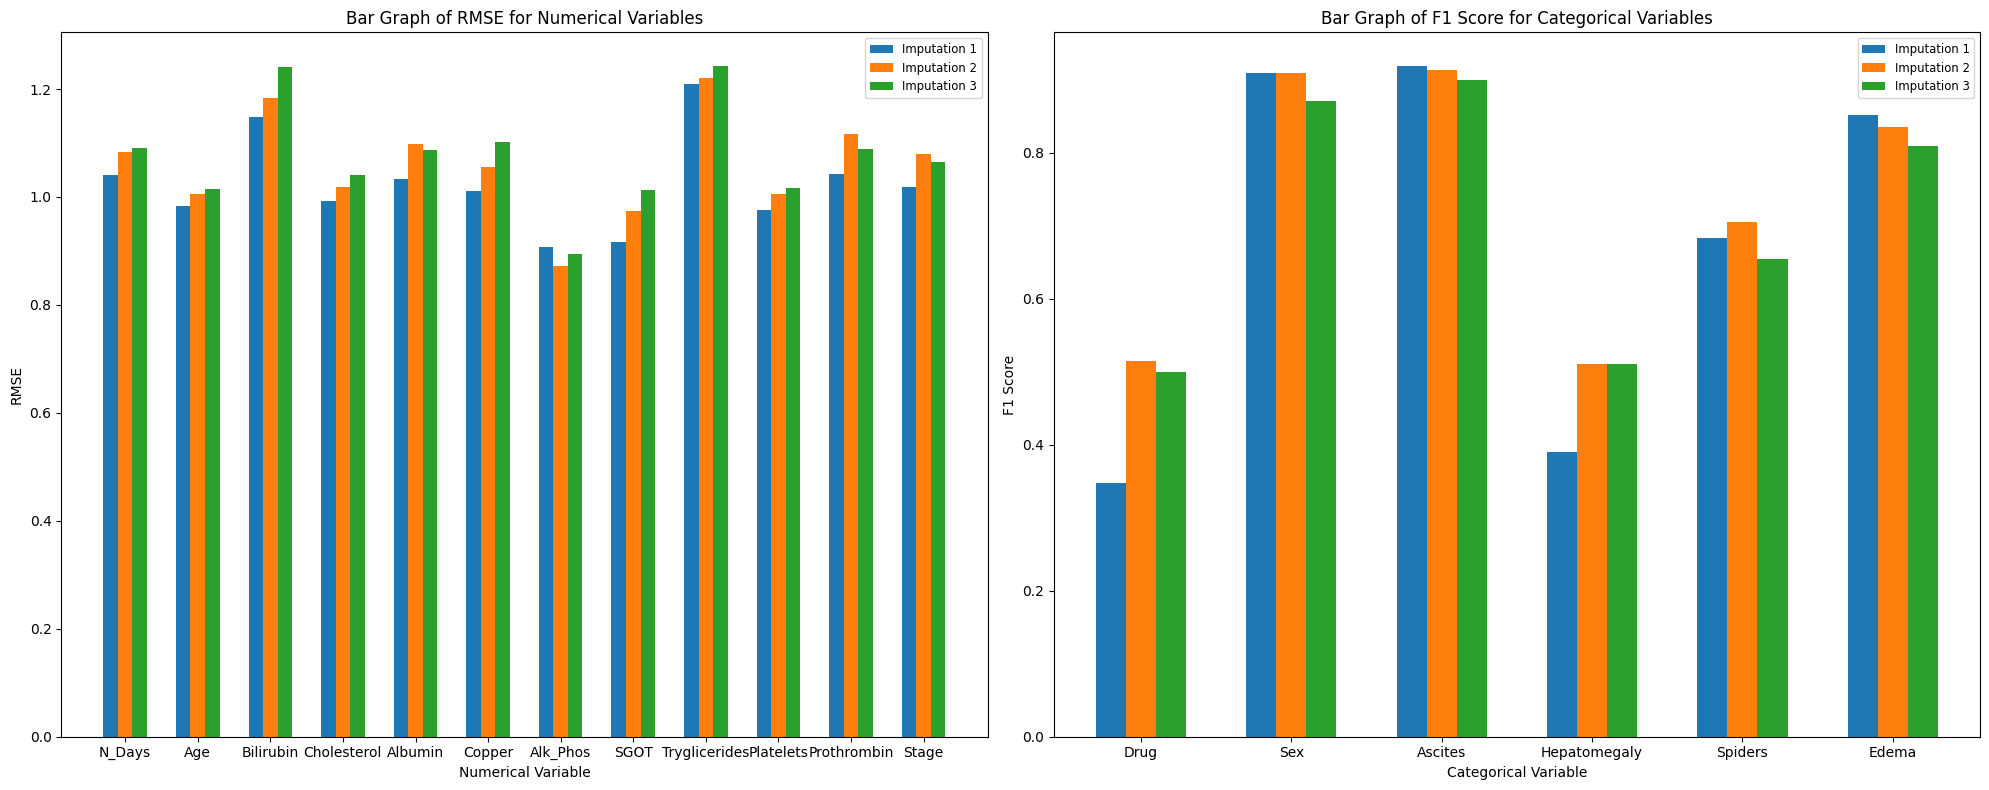

In [ ]:
# define stores for the rmse and f1 of each method
rmse_store = [list(calc_num_metrics(actual_entries_X, imputed_entries_store, num_cols)['RMSE']) for imputed_entries_store in [imputed1_entries_store, imputed2_entries_store, imputed3_entries_store]]
f1_store = [list(calc_categorical_metrics(actual_entries_X, imputed_entries_store, categorical_cols)['F1 Score']) for imputed_entries_store in [imputed1_entries_store, imputed2_entries_store, imputed3_entries_store]]

# create subplots to plot both metrics and compare for each method
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# plot the bars for the numerical variables
for i in range(len(rmse_store)):
    axs[0].bar([x + i * 0.2 for x in list(range(len(rmse_store[0])))], rmse_store[i], 0.2, label=f'Imputation {i+1}')

# add labels and title for the numerical variables
axs[0].set_xlabel('Numerical Variable')
axs[0].set_ylabel('RMSE')
axs[0].set_title('Bar Graph of RMSE for Numerical Variables')
axs[0].set_xticks([x + 0.2 for x in list(range(len(rmse_store[0])))])
axs[0].set_xticklabels(num_cols)
axs[0].legend(fontsize='smaller')

# plot the bars for the categorical variables
for i in range(len(f1_store)):
    axs[1].bar([x + i * 0.2 for x in list(range(len(f1_store[0])))], f1_store[i], 0.2, label=f'Imputation {i+1}')

# add labels and title for the categorical variables
axs[1].set_xlabel('Categorical Variable')
axs[1].set_ylabel('F1 Score')
axs[1].set_title('Bar Graph of F1 Score for Categorical Variables')
axs[1].set_xticks([x + 0.2 for x in list(range(len(f1_store[0])))])
axs[1].set_xticklabels(categorical_cols)
axs[1].legend(fontsize='smaller')

# improve layout and plot
plt.tight_layout()
plt.show()

This shows that the first imputation method had a lower RMSE and better f1 score on all variables except "Drug" and "Hepatomegaly". The significant decrease in f1 score for these variables may be due to the fact that each one has a roughly equal amount of entries in each category. This means that by selecting the most common entry to impute for each one, it's wrong almost half the time. In contrast, most other categorical variables had one category that was much more common than the others, meaning that imputation 1 performed well.

The second and third imputation methods were further away from the true data value on average, with imputation 2 performing better on categorical variables (higher f1 score) and imputation 3 performing better on numerical variables (lower RMSE). Despite these more complex methods giving imputed data that's further away from the true values, it may be the case that machine learning models trained on these datasets could still perform better.

We can now upload the predictions of the models trained on each dataset to Kaggle. The results we obtained are:
* Log loss 0.47655 for the model trained on non_imputed data
* Log loss 0.48455 for the model trained on data imputed using method 1
* Log loss 0.44962 for the model trained on data imputed using method 2
* Log loss 0.44971 for the model trained on data imputed using method 3

Below is code to display these results nicely.

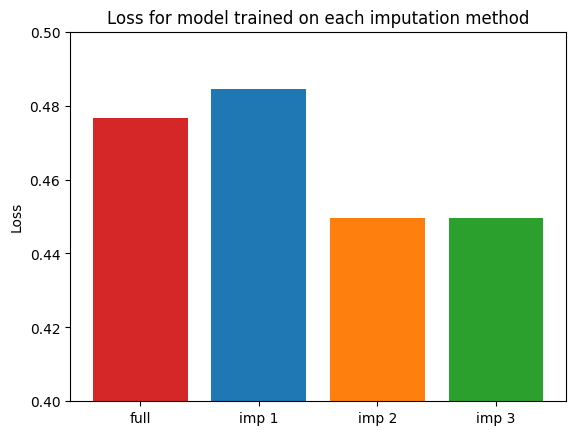

In [ ]:
# make a bar chart to display losses for each model
fig_imp, ax_imp = plt.subplots()

# fill in the scores we obtained from Kaggle
imp_models = ['full', 'imp 1', 'imp 2', 'imp 3']
losses = [0.47655, 0.48455, 0.44962, 0.44971]
bar_colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green']

# plot the results on a bar graph
ax_imp.bar(imp_models, losses, label=imp_models, color=bar_colors)
ax_imp.set_ylim([0.4, 0.5])
ax_imp.set_ylabel('Loss')
ax_imp.set_title('Loss for model trained on each imputation method')

# show the plot
plt.show()

This bar graph shows a clear performance increase of the imputation 2 and imputation 3 models. Suprisingly, despite producing data that was further away from the true value than that of imputation 1 (or indeed the non-imputed data), the models trained on data using these two imputation methods performed even better than the baseline.

One explanation for this could be that without introducing imputation into the dataset, the model we chose overfits on the dataset, leading to worse generalisation of the final model. Then when some data was removed and imputed using these methods, the model learned on worse data and couldn't rely on a small subset of input variables to make its predictions.

The conclusion of our analysis of imputation methods is that, while the simple imputer gives values closer to the true input data, the more sopohisticated algorithms we employed yielded better models, which were even able to perform better than expected on unseen data. We reccomend that one of these models would be appropriate for use when training a model on input data with missing values.

## Pipeline

The pipeline will handle:
- Data Cleaning
- Feature Engineering
- Unbalanced Data
- Scaling/Normalization
- Imputation Placeholder



### Data Cleaning and Preparation Function Summary

The `clean_and_prep(data)` function readies the dataset for machine learning by addressing missing data, managing outliers, and adjusting feature formats.

1. **Missing Data**: It fills in gaps in the dataset to ensure all data points are complete.

2. **Outliers**: The function reduces the influence of extremely high values in "Bilirubin" and "Copper" by setting a cap, which helps maintain a balanced analysis.

3. **Data Transformation**:
   - **Numeric Data**: transforms "Bilirubin", "Copper", "Alk_Phos", and "SGOT" to lessen the effect of skewed distributions and converts "Age" into years for better understanding.
   - **Categorical Data**: changes categories, like "Sex", into numeric values to fit the requirements of machine learning models.

4. **Overall Preparation**: The function ensures that both numeric and categorical data are properly cleaned and formatted for analysis and model training. The result is a dataset that's clean and ready for the next steps in the modeling process.

This methodical approach to data preparation enhances the dataset’s readiness for machine learning, aiming to improve the accuracy of future models.

In [ ]:
# Function for cleaning data
def clean_and_prep(data):
    """
    Cleans the dataset by applying imputation methods and handling outliers.

    Parameters:
    - data: pandas DataFrame containing the data to be cleaned.

    Returns:
    - The cleaned pandas DataFrame.
    """
    
    # handle outliers:
    high = np.percentile(data["Bilirubin"], 95)  # 95th percentile
    data["Bilirubin"] = np.where(data["Bilirubin"] > high, high, data["Bilirubin"])

    high_copper = np.percentile(data["Copper"], 95)  # 95th percentile
    data["Copper"] = np.where(data["Copper"] > high_copper, high_copper, data["Copper"])

    data_tn = transform_numerical(data)

    data_tc = transform_categorical(data_tn)

    return data_tc


# Function for transforming numerical features
def transform_numerical(data):
    """
    Applies transformations to numerical features to address skewness and improve
    interpretability.

    Parameters:
    - data: pandas DataFrame with the numerical features to be transformed.

    Returns:
    - The DataFrame with transformed numerical features.
    """

    # Log transformation to address skewness
    data["Bilirubin"] = np.log(data["Bilirubin"] + 1).astype(float)
    data["Copper"] = np.log(data["Copper"] + 1).astype(float)
    data["Alk_Phos"] = np.log(data["Alk_Phos"] + 1).astype(float)
    data["SGOT"] = np.log(data["SGOT"] + 1).astype(float)

    # Normalize Age to be in years for better interpretability
    data["Age_in_Years"] = (data["Age"] / 365.25).astype(float)

    return data.drop("Age", axis=1)


# Function for transforming categorical features
def transform_categorical(data):
    """
    Transforms categorical features into numerical format suitable for machine
    learning models.

    Parameters:
    - data: pandas DataFrame with the categorical features to be transformed.

    Returns:
    - The DataFrame with transformed categorical features.
    """
    data["Is_Male"] = (data["Sex"] == "M").astype(float)
    
    return data.drop("Sex", axis=1)

### Defining Variables for Modeling

1. **Data Preprocessing:** The `clean_and_prep` function is applied to both the training and test datasets for consistent cleaning and preparation. This step ensures that outliers and missing values are managed, and variables are formatted correctly for modeling.

2. **Choosing Features:**
   - **Important Columns:** We select specific features (`columns_to_keep`) based on their connection to the target variable (`Status`) and how well they might predict it. Factors like `N_Days`, `Age_in_Years`, and `Bilirubin` are chosen for their known importance from domain expertise and exploratory analysis.
   - **Target Variable:** We separate out the `Status` variable to clearly define what the model is trying to predict.

3. **Classifying Features:**
   - **Numerical Features:** These are continuous variables like lab results or age, providing direct, quantitative input for the model.
   - **Categorical Features:** Categories, such as the type of drug used or presence of ascites, are identified for special preprocessing steps like one-hot encoding, which makes them usable for machine learning.

4. **Enhancing Features:** We modify certain features to make them more informative for the model. For example, we change `Sex` to a binary `Is_Male` variable and recalculate age into years (`Age_in_Years`), standardizing the measurement for better model understanding and performance.

This structured preparation ensures our features are well-defined, relevant, and properly formatted for effective model training.


In [ ]:
# Preprocess data
train_data_prep = clean_and_prep(raw_training_data)
test_data_prep = clean_and_prep(raw_test_data)

# Define the columns to keep
columns_to_keep = [
    "N_Days", "Age_in_Years", "Is_Male", "Bilirubin", "Cholesterol", "Albumin",
    "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin",
    "Stage", "Drug", "Ascites", "Hepatomegaly", "Spiders", 
    "Edema",
]
target_attribute = ["Status"]

train_data_prep_col = train_data_prep[columns_to_keep + target_attribute]
test_data_prep_col = test_data_prep[columns_to_keep]

# Numerical and categorical features
numerical_features = [
    "N_Days", "Age_in_Years","Bilirubin", "Cholesterol", "Albumin",
    "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", 
    "Prothrombin", "Stage",
]

# Updated categorical features list after transformations
categorical_features = [ "Drug", "Ascites", "Hepatomegaly", 
                        "Spiders", "Edema",
    # 'Sex' has been transformed to 'Is_Male', which is now a numerical feature]
]

### Data Transformation and Pipeline Setup

#### ColumnTransformer Setup
The `preprocessor` in our pipeline standardizes numerical data and turns categorical data into one-hot encoded variables.

#### Sampling Strategies in Pipelines

- **SMOTE Pipeline (`smote_pipeline`)**: Uses the SMOTE technique to oversample the minority class by generating new, synthetic examples.
- **Undersampling Pipeline (`undersample_pipeline`)**: Applies Random Undersampling to decrease the size of the majority class, making the dataset more balanced.

#### Complete Training Pipelines

1. **For SMOTE (`full_pipeline_train_smote`)**:
   - Includes `preprocessor` for initial data handling.
   - Integrates SMOTE for balancing classes.
   - A model can be added later to this pipeline for training.
   - **Advantages of SMOTE**:
     - Helps prevent overfitting by creating varied synthetic examples.
     - Aids in learning broader patterns for better generalization.
     - Useful in various fields like healthcare and fraud detection.

2. **For Random Undersampling (`full_pipeline_train_undersample`)**:
   - Begins with the same `preprocessor`.
   - Uses Random Undersampling to adjust class sizes.
   - Ready for a model to be fitted within the pipeline.
   - **Benefits of Random Undersampling**:
     - Cuts down training time, useful for large datasets.
     - Boosts the relative importance of the minority class.
     - Easy to apply without needing complex methods.

#### Test Data Preparation

- The test data undergoes the same preprocessing as training data to ensure consistency using `full_pipeline_test`.
- The steps for splitting, encoding, and preparing the data are clearly defined for transparency and repeatability.


In [ ]:
# Define the ColumnTransformer to handle numerical and categorical transformations
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", StandardScaler(), numerical_features),
        ("categorical", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categorical_features),
    ]
)

# Define the sampling pipeline with SMOTE only 
smote_pipeline = imblearnPipeline(steps=[
    ("smote", SMOTE(random_state=42)),  # SMOTE for oversampling
   
])

# Define the full pipeline including preprocessing, SMOTE, and model fitting
full_pipeline_train_smote = imblearnPipeline(steps=[
    ("preprocessor", preprocessor),  # Preprocessing step
    ("sampling", smote_pipeline),  # Sampling step with SMOTE only
])

# Define the sampling pipeline with Random Undersampling only
undersample_pipeline = imblearnPipeline(steps=[
    ("undersample", RandomUnderSampler(random_state=42)),  # Random Undersampling
   
])

# Define the full pipeline including preprocessing, Random Undersampling, and model fitting
full_pipeline_train_undersample = imblearnPipeline(steps=[
    ("preprocessor", preprocessor),  # Preprocessing step
    ("sampling", undersample_pipeline),  # Sampling step with Random Undersampling only
])

# Define the test pipeline for preprocessing only
full_pipeline_test = imblearnPipeline(steps=[
     ("preprocessor", preprocessor),
])

# Split the training data into features (X_train) and target (y_train)
X_train = raw_training_data.drop(columns=['Status'])
y_train = raw_training_data['Status']

# Same for Test Data
X_test = raw_test_data

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Split the encoded target variable along with features into training and validation sets
X_train_encoded, X_val_encoded, y_train_encoded, y_val_encoded = train_test_split(
    X_train, y_train_encoded, test_size=0.2, random_state=42)

# Fit and transform the training data using the pipeline with SMOTE
X_train_resampled_smote, y_train_resampled_smote = full_pipeline_train_smote.fit_resample(X_train_encoded, y_train_encoded)

# Fit and transform the training data using the pipeline with Random Undersampling
X_train_resampled_undersample, y_train_resampled_undersample = full_pipeline_train_undersample.fit_resample(X_train_encoded, y_train_encoded)


# Transform the test data with the test pipeline (not including sampling)
prepared_test_data = full_pipeline_test.transform(X_test)

## Model Training and Validation

### Splitting Resampled Data into Training and Validation Sets

After balancing the dataset with SMOTE and Random Undersampling, we split the data to create separate training and validation sets. This step is vital for assessing how well our models perform on data they haven’t been trained on.

#### Training and Validation Split with SMOTE

- We split the SMOTE-augmented data into an 80/20 ratio for training and validation. The aim is to have enough data for the model to learn from while setting aside a part for validation.
- SMOTE helps balance the dataset by adding new, synthetic samples of the minority class, which can enhance the model’s ability to predict these cases.

#### Training and Validation Split with Random Undersampling

- The data balanced by Random Undersampling also follows an 80/20 training to validation split. With Random Undersampling, we lessen the dataset size, which can speed up model training.
- Although undersampling is quick and straightforward, it can reduce the amount of data available, which might limit the model’s learning potential.

#### The Role of the Validation Set

The validation set is essential for checking the model’s predictions against new data. This is how we spot problems like overfitting and adjust the model accordingly. By comparing how models trained on differently balanced data perform on the validation set, we can fine-tune them to work best with balanced data.


In [ ]:
# Split the resampled training data into training and validation sets (80/20 split) for SMOTE
X_train_final_smote, X_val_smote, y_train_final_smote, y_val_smote = train_test_split(
    X_train_resampled_smote, y_train_resampled_smote, test_size=0.2, random_state=42
)
# the quantity in training and validation set for SMOTE
print("Number of training sets for SMOTE:", len(X_train_final_smote), "Number of validation sets for SMOTE:", len(X_val_smote))
print("Number of training target for SMOTE:", len(y_train_final_smote), "Number of validation target for SMOTE:", len(y_val_smote))

# Split the resampled training data into training and validation sets (80/20 split) for Random Undersampling
X_train_final_undersample, X_val_undersample, y_train_final_undersample, y_val_undersample = train_test_split(
    X_train_resampled_undersample, y_train_resampled_undersample, test_size=0.2, random_state=42
)
# the quantity in training and validation set for Random Undersampling
print("Number of training sets for Random Undersampling:", len(X_train_final_undersample), "Number of validation sets for Random Undersampling:", len(X_val_undersample))
print("Number of training target for Random Undersampling:", len(y_train_final_undersample), "Number of validation target for Random Undersampling:", len(y_val_undersample))


Number of training sets for SMOTE: 9597 Number of validation sets for SMOTE: 2400
Number of training target for SMOTE: 9597 Number of validation target for SMOTE: 2400
Number of training sets for Random Undersampling: 535 Number of validation sets for Random Undersampling: 134
Number of training target for Random Undersampling: 535 Number of validation target for Random Undersampling: 134


### Examining Class Balance in Resampled Data

Resampling methods like SMOTE and Random Undersampling are used to make sure each class in our dataset is represented equally. This balance is key for training models that are fair and accurate across all categories.

#### Balance with SMOTE

- **What SMOTE Does:** It creates new, synthetic samples to boost the numbers of the minority class, aiming for equal representation.
- **What We See:** The balanced dataset now shows that each class makes up about a third of the data, proving that SMOTE has done its job to even out the class frequencies.

#### Balance with Random Undersampling

- **What Undersampling Does:** It trims down the majority class to the size of the minority class for balance.
- **What We See:** The dataset balanced by Random Undersampling mirrors the equal class distribution seen with SMOTE, indicating that the approach has effectively equalized the representation of each class.

Both methods achieve the goal of creating a dataset where no class outweighs another, setting the stage for unbiased model training.

In [ ]:
# "status" Proportion in resampled training set (SMOTE)
print("Proportion in resampled training set for SMOTE:")
print(pd.Series(y_train_resampled_smote).value_counts() / len(y_train_resampled_smote))

# "status" Proportion in resampled training set (Random Undersampling)
print("Proportion in resampled training set for Random Undersampling:")
print(pd.Series(y_train_resampled_undersample).value_counts() / len(y_train_resampled_undersample))


Proportion in resampled training set for SMOTE:
1    0.333333
0    0.333333
2    0.333333
Name: count, dtype: float64
Proportion in resampled training set for Random Undersampling:
0    0.333333
1    0.333333
2    0.333333
Name: count, dtype: float64


### Training Models with Balanced Data

We train SVM, RandomForest, and LogisticRegression models on datasets balanced through SMOTE and Random Undersampling. Each model’s training process is tailored to handle balanced data effectively.

#### SVM Model
- Configured to estimate probabilities, essential for evaluating model performance with log loss metrics.
- SVMs are trained on both SMOTE and undersampled data to gauge their performance on datasets with a more even class distribution.

#### RandomForest Model
- Uses default settings and is recognized for performing well even when classes are imbalanced.
- We train RandomForest on each balanced dataset to see how it fares when classes are equalized.

#### LogisticRegression Model
- Set up with standard options and chosen for its straightforward results on data where classes are clearly separated.
- Trained on both types of balanced data to understand its strengths in these scenarios.

#### Overview of Training
- With **SMOTE**, we look at how adding synthetic samples influences model accuracy.
- With **Random Undersampling**, we examine the impact of reducing data size for balance on the models’ ability to generalize.

This process helps us figure out the most effective way to prepare data for models that need to predict outcomes fairly across all classes.

In [ ]:
# SVM model and enable probability estimation for logloss calculation (for SMOTE)
svm_clf_smote = SVC(probability=True)  # Running time is relatively long
# RandomForest model (for SMOTE)
random_forest_clf_smote = RandomForestClassifier()
# LogisticRegression model (for SMOTE)
logistic_reg_clf_smote = LogisticRegression()

# Training models (for SMOTE)
svm_clf_smote.fit(X_train_resampled_smote, y_train_resampled_smote)
random_forest_clf_smote.fit(X_train_resampled_smote, y_train_resampled_smote)
logistic_reg_clf_smote.fit(X_train_resampled_smote, y_train_resampled_smote)

# SVM model and enable probability estimation for logloss calculation (for Random Undersampling)
svm_clf_undersample = SVC(probability=True)  # Running time is relatively long
# RandomForest model (for Random Undersampling)
random_forest_clf_undersample = RandomForestClassifier()
# LogisticRegression model (for Random Undersampling)
logistic_reg_clf_undersample = LogisticRegression()

# Training models (for Random Undersampling)
svm_clf_undersample.fit(X_train_resampled_undersample, y_train_resampled_undersample)
random_forest_clf_undersample.fit(X_train_resampled_undersample, y_train_resampled_undersample)
logistic_reg_clf_undersample.fit(X_train_resampled_undersample, y_train_resampled_undersample)


LogisticRegression()

## Preparing Target Variables and Training XGBClassifier

#### Turning Labels into Numbers

- **Why It's Done:** The XGBClassifier needs target variables (like `y_train_resampled_smote` and `y_train_resampled_undersample`) in number form, not as text or categories.
- **How It's Done:** We use scikit-learn's `LabelEncoder` to change the target labels from categories into numbers. This step makes sure the XGBClassifier can work with our data.

#### Training the XGBClassifier

- **Setting Up the Model:** We start two XGBClassifier models, one for each type of balanced data (SMOTE and Random Undersampling). We stick with the default settings for these models.
- **The Training Steps:**
  - The model for the SMOTE data is taught using the balanced data and the newly numbered labels.
  - We do the same for the model using Random Undersampling data.

#### Understanding the Training Results

After training, we can see how the XGBClassifier was set up, including which settings were used. This is helpful for making sure everything is correct and that the model is ready for complex tasks like predicting different classes. The model aims to predict class probabilities, which is important for evaluating its performance accurately.

With these steps, the XGBClassifier is expected to perform well on balanced datasets, making accurate predictions across various classes. The careful preparation of the target variables and selection of model settings are key to addressing data imbalance and achieving good results.

In [ ]:
# When XGBClassifier ​​processes target variables, it expects these variables to be numeric.
le=LabelEncoder()

# Label encode the target variable for SMOTE training set
y_train_resampled_smote_label = le.fit_transform(y_train_resampled_smote)

# Label encode the target variable for Random Undersampling training set
y_train_resampled_undersample_label = le.fit_transform(y_train_resampled_undersample)

# XGBClassifier model for SMOTE
XGB_clf_smote = XGBClassifier()

# XGBClassifier model for Random Undersampling
XGB_clf_undersample = XGBClassifier()

# Training models
XGB_clf_smote.fit(X_train_resampled_smote, y_train_resampled_smote_label) 
XGB_clf_undersample.fit(X_train_resampled_undersample, y_train_resampled_undersample_label) 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### Checking Model Performance with Validation Data

We follow a few steps to see how well our models, trained with SMOTE data, do on validation data:

1. **Prepping Validation Data:** We make sure the validation data (`X_val_encoded`) is processed the same way our models expect, using the pipeline’s preprocessor.

2. **Making Predictions:** Each model (SVM, Random Forest, Logistic Regression, and XGBoost) trained on SMOTE data then predicts outcomes for the validation set. We're looking at how likely each class is according to the models.

3. **Measuring Accuracy with Log Loss:** We use log loss to see how accurate the predictions are. The closer the log loss is to zero, the better the model did.

#### Log Loss Results for Models
- **SVM:** Log loss is 0.5839.
- **Random Forest:** Log loss is 0.4990.
- **Logistic Regression:** Log loss is 0.7460.
- **XGBoost:** Log loss is 0.5152.

Random Forest and XGBoost came out on top, showing they’re more accurate on the validation data. We’ll focus on these two for an ensemble model, hoping to combine their strengths for even better predictions.

In [ ]:
# Transform the validation data using the preprocessor in the pipeline
X_val_preprocessed = full_pipeline_test.transform(X_val_encoded)

# Predict probabilities for validation set using models trained on SMOTE-augmented data
y_val_proba_svm_smote = svm_clf_smote.predict_proba(X_val_preprocessed)
y_pred_proba_rf_smote = random_forest_clf_smote.predict_proba(X_val_preprocessed)
y_pred_proba_LR_smote = logistic_reg_clf_smote.predict_proba(X_val_preprocessed)
y_pred_proba_XGB_smote = XGB_clf_smote.predict_proba(X_val_preprocessed)

# Calculate log loss for each model on validation set
logloss_val_svm_smote = log_loss(y_val_encoded, y_val_proba_svm_smote)
loss_val_rf_smote = log_loss(y_val_encoded, y_pred_proba_rf_smote)
loss_val_LR_smote = log_loss(y_val_encoded, y_pred_proba_LR_smote)
loss_val_XGB_smote = log_loss(y_val_encoded, y_pred_proba_XGB_smote)

# Print SMOTE log loss values for each model
print("SMOTE log loss value for each moedel")
print(f"SVM model Validation set Log Loss: {logloss_val_svm_smote}")
print(f"Random forest model Validation set Log Loss: {loss_val_rf_smote}")
print(f"Logistic regression model Validation set Log Loss: {loss_val_LR_smote}")
print(f"XGBoost model Validation set Log Loss: {loss_val_XGB_smote}")


SMOTE log loss value for each moedel
SVM model Validation set Log Loss: 0.5839805124704097
Random forest model Validation set Log Loss: 0.49900554559470933
Logistic regression model Validation set Log Loss: 0.7460301454733721
XGBoost model Validation set Log Loss: 0.5152148070152034


### Checking Model Performance with Undersampled Data

We look at how models trained on data balanced by Random Undersampling do with the validation set. This process is similar to how we checked models with SMOTE data, but now we're focusing on undersampled data to see its effect on model accuracy.

#### Making Predictions

Each model (SVM, Random Forest, Logistic Regression, and XGBoost), after being trained on undersampled data, predicts outcomes for the validation set. We're especially interested in the models' estimated probabilities for each class because they help us measure accuracy through log loss.

#### Evaluating Accuracy with Log Loss

We calculate log loss for each model:
- **SVM:** Log loss is 0.7522.
- **Random Forest:** Log loss is 0.7318.
- **Logistic Regression:** Log loss is 0.7578.
- **XGBoost:** Log loss is 0.8953.

Lower log loss means better accuracy. 

#### Analysis

Models trained with undersampled data have higher log loss (less accurate) than those trained with SMOTE data. This suggests Random Undersampling might not capture all the details in the data as well as SMOTE, possibly making models less accurate on new data.

Choosing between SMOTE and Random Undersampling depends on what's most important for your project and how detailed your data needs to be for accurate predictions. While SMOTE might reduce log loss better in some cases, undersampling could be faster and still offer useful insights.


In [ ]:

# Predict probabilities for validation set using models trained on undersampling-augmented data
y_val_proba_svm_undersample = svm_clf_undersample.predict_proba(X_val_preprocessed)
y_pred_proba_rf_undersample = random_forest_clf_undersample.predict_proba(X_val_preprocessed)
y_pred_proba_LR_undersample = logistic_reg_clf_undersample.predict_proba(X_val_preprocessed)
y_pred_proba_XGB_undersample = XGB_clf_undersample.predict_proba(X_val_preprocessed)

# Calculate log loss for each model on validation set
logloss_val_svm_undersample = log_loss(y_val_encoded, y_val_proba_svm_undersample)
logloss_val_rf_undersample = log_loss(y_val_encoded, y_pred_proba_rf_undersample)
logloss_val_LR_undersample = log_loss(y_val_encoded, y_pred_proba_LR_undersample)
logloss_val_XGB_undersample = log_loss(y_val_encoded, y_pred_proba_XGB_undersample)

# Print log loss values for each model
print("undersample log loss value for each model")
print(f"SVM model Validation set Log Loss: {logloss_val_svm_undersample}")
print(f"Random forest model Validation set Log Loss: {logloss_val_rf_undersample}")
print(f"Logistic regression model Validation set Log Loss: {logloss_val_LR_undersample}")
print(f"XGBoost model Validation set Log Loss: {logloss_val_XGB_undersample}")


undersample log loss value for each moedel
SVM model Validation set Log Loss: 0.7522299067328889
Random forest model Validation set Log Loss: 0.7318328247852743
Logistic regression model Validation set Log Loss: 0.7578296715596723
XGBoost model Validation set Log Loss: 0.8952895263784781


## Comparing Sampling Techniques with Log Loss

### What the Chart Shows

The bar chart helps us see the log loss for models trained with two different approaches: SMOTE and Random Undersampling. SMOTE's results, shown in sky blue, usually have lower log loss than Undersampling's, in light green.

Low log loss means a model is more accurate. The chart tells us that no matter the model, using SMOTE generally leads to more accurate predictions on our validation data.

### Key Takeaways

- **SMOTE Outperforms Undersampling**: The chart makes it clear that SMOTE better enhances model accuracy, as seen by the lower log loss scores for all models we looked at. By creating synthetic data points, SMOTE provides a richer dataset that helps models learn better and generalize more effectively to new data.
  
- **Undersampling's Trade-off**: Although Undersampling makes training faster by reducing dataset size, this might result in losing valuable information. This is reflected in the higher log loss scores, suggesting a drop in prediction accuracy.

### Making a Choice

Deciding whether to use SMOTE or Undersampling depends on your specific needs, such as the nature of your data, the computational resources at hand, and what you're trying to achieve with your model. While SMOTE has shown better performance in our tests, each project's unique requirements should guide the final choice of technique.

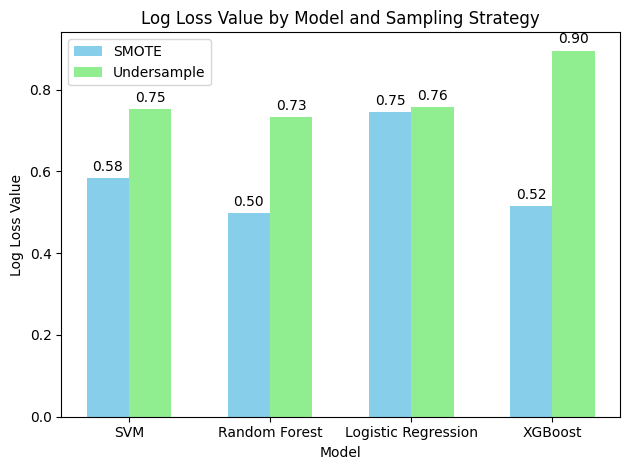

In [ ]:
# Prepare the data
models = ['SVM', 'Random Forest', 'Logistic Regression', 'XGBoost']
smote_values = [logloss_val_svm_smote, loss_val_rf_smote, loss_val_LR_smote, loss_val_XGB_smote]
undersample_values = [logloss_val_svm_undersample, logloss_val_rf_undersample, logloss_val_LR_undersample, logloss_val_XGB_undersample]

x = np.arange(len(models)) 
width = 0.3  

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, smote_values, width, label='SMOTE', color='skyblue')
bars2 = ax.bar(x + width/2, undersample_values, width, label='Undersample', color='lightgreen')

ax.set_xlabel('Model')
ax.set_ylabel('Log Loss Value')
ax.set_title('Log Loss Value by Model and Sampling Strategy')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Set labels on bar chart
ax.bar_label(bars1, padding=3, fmt='%.2f')
ax.bar_label(bars2, padding=3, fmt='%.2f')

fig.tight_layout()

plt.show()

### Prediction and Performance Metrics for Models Trained with SMOTE

This cell uses models trained on the SMOTE-augmented data to predict the 'Status' feature of the validation set. Performance metrics like precision, recall, f1-score, and accuracy are calculated to evaluate model effectiveness.

- **Random Forest and XGBoost** show remarkable performance with perfect scores across all metrics.
- **SVM and Logistic Regression** show relatively lower, yet still strong, scores indicating effective classification, though with some misclassifications.

These metrics provide detailed insights into each model's predictive strengths and weaknesses when handling balanced data via SMOTE.

In [ ]:
# Predict validation set data for 'Status' (SMOTE)
y_pred_SVM_smote = svm_clf_smote.predict(X_val_smote)
y_pred_random_forest_smote = random_forest_clf_smote.predict(X_val_smote)
y_pred_logistic_reg_smote = logistic_reg_clf_smote.predict(X_val_smote)
y_pred_XGB_smote = XGB_clf_smote.predict(X_val_smote)


# precision, recall, f1-score, accuracy (SMOTE)
report_SVM_smote = classification_report(y_val_smote, y_pred_SVM_smote, zero_division=0)
report_random_forest_smote = classification_report(y_val_smote, y_pred_random_forest_smote, zero_division=0)
report_logistic_regression_smote = classification_report(y_val_smote, y_pred_logistic_reg_smote, zero_division=0)
report_XGB_smote = classification_report(y_val_smote, y_pred_XGB_smote, zero_division=0) 

print("For SMOTE:")
print(f"SVM: {report_SVM_smote}")
print(f"Random forest: {report_random_forest_smote}")
print(f"Logistic regression: {report_logistic_regression_smote}")
print(f"XGB: {report_XGB_smote}")


For SMOTE:
SVM:               precision    recall  f1-score   support

           0       0.82      0.80      0.81       803
           1       0.86      0.94      0.90       802
           2       0.87      0.79      0.83       795

    accuracy                           0.85      2400
   macro avg       0.85      0.85      0.85      2400
weighted avg       0.85      0.85      0.85      2400

Random forest:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       803
           1       1.00      1.00      1.00       802
           2       1.00      1.00      1.00       795

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400

Logistic regression:               precision    recall  f1-score   support

           0       0.66      0.70      0.68       803
           1       0.63      0.65      0.64       802
           2       0.69

### Prediction and Performance Metrics for Models Trained with Random Undersampling

Following predictions on the validation set using models trained with Random Undersampling, the cell calculates and prints the precision, recall, f1-score, and accuracy.

- **Random Forest and XGBoost** maintain their exceptional performance with perfect metrics, consistent with their SMOTE-trained counterparts.
- **SVM and Logistic Regression** exhibit lower performance compared to the SMOTE-based models, suggesting that Random Undersampling might lead to some loss of information due to reduced training data size.

The reported metrics highlight how each model copes with the class balance achieved by Random Undersampling.

In [ ]:
# Predict validation set data for 'Status' (Random Undersampling)
y_pred_SVM_undersample = svm_clf_undersample.predict(X_val_undersample)
y_pred_random_forest_undersample = random_forest_clf_undersample.predict(X_val_undersample)
y_pred_logistic_reg_undersample = logistic_reg_clf_undersample.predict(X_val_undersample)
y_pred_XGB_undersample = XGB_clf_undersample.predict(X_val_undersample)

# precision, recall, f1-score, accuracy (Random Undersampling)
report_SVM_undersample = classification_report(y_val_undersample, y_pred_SVM_undersample, zero_division=0)
report_random_forest_undersample = classification_report(y_val_undersample, y_pred_random_forest_undersample, zero_division=0)
report_logistic_regression_undersample = classification_report(y_val_undersample, y_pred_logistic_reg_undersample, zero_division=0)
report_XGB_undersample = classification_report(y_val_undersample, y_pred_XGB_undersample, zero_division=0) 

print("For Random Undersampling:")
print(f"SVM: {report_SVM_undersample}")
print(f"Random forest: {report_random_forest_undersample}")
print(f"Logistic regression: {report_logistic_regression_undersample}")
print(f"XGB: {report_XGB_undersample}")


For Random Undersampling:
SVM:               precision    recall  f1-score   support

           0       0.81      0.82      0.81        56
           1       0.52      0.71      0.60        31
           2       0.89      0.66      0.76        47

    accuracy                           0.74       134
   macro avg       0.74      0.73      0.72       134
weighted avg       0.77      0.74      0.74       134

Random forest:               precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       1.00      1.00      1.00        31
           2       1.00      1.00      1.00        47

    accuracy                           1.00       134
   macro avg       1.00      1.00      1.00       134
weighted avg       1.00      1.00      1.00       134

Logistic regression:               precision    recall  f1-score   support

           0       0.75      0.70      0.72        56
           1       0.37      0.52      0.43        31
        

### Cross-Validation Log Loss for Models Trained with SMOTE

Cross-validation is performed for models trained on the SMOTE-resampled data, utilizing a custom scorer for log loss. The results are:

- **SVM Cross-Validation Log Loss:** 0.4556 (± 0.0311)
- **Random Forest Cross-Validation Log Loss:** 0.3372 (± 0.0467)
- **Logistic Regression Cross-Validation Log Loss:** 0.7773 (± 0.0409)

These scores provide an estimate of model performance by averaging the log loss across multiple validation sets. The Random Forest model stands out with the lowest log loss, indicating high predictive accuracy. Logistic Regression shows a higher log loss, indicating some challenges with the SMOTE-resampled data.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Define a custom scorer for log loss
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Define the models
models = {
    "SVM": svm_clf_smote,
    "Random Forest": random_forest_clf_smote,
    "Logistic Regression": logistic_reg_clf_smote,
    "XGBoost": XGB_clf_smote
}

# Perform cross-validation for each model
for name, model in models.items():
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train_resampled_smote, y_train_resampled_smote, 
                                cv=5, scoring=log_loss_scorer)
    
    # Calculate mean and standard deviation of cross-validation scores
    mean_score = -cv_scores.mean()  # Taking negative as we used greater_is_better=False
    std_score = cv_scores.std()
    
    # Print the results
    print(f"{name} Cross-Validation Log Loss: {mean_score:.4f} (+/- {2 * std_score:.4f})")


SVM Cross-Validation Log Loss: 0.4556 (+/- 0.0311)
Random Forest Cross-Validation Log Loss: 0.3372 (+/- 0.0467)
Logistic Regression Cross-Validation Log Loss: 0.7773 (+/- 0.0409)


KeyboardInterrupt: 

## Explaining the Confusion Matrix Visualization Function

The `plot_confusion_matrices()` function is designed to visually present confusion matrices for various classifiers, making it easier to compare their performance directly.

### How the Function Works

- **Inputs for Matrices:** It takes confusion matrices for classifiers like SVM, Random Forest, Logistic Regression, and XGBoost as inputs. This setup allows us to see how each model predicts across different classes.
- **Custom Titles:** You can add a unique suffix to each plot's title with the `title_suffix` parameter, helping to distinguish between different tests or datasets.

### What the Output Looks Like

The function creates a set of plots in a 2x2 layout, one for each classifier:
- **Colors:** It uses a blue color scale in the heatmaps to show the count of predictions, with darker blues indicating higher numbers.
- **Labels:** Predictions are labeled for clarity, and the axes are marked to show which are predicted and which are true labels.

### Why It's Useful

Using `plot_confusion_matrices()` helps us quickly see how well each classifier is doing, highlighting their strengths and weaknesses in a visually accessible way. It's a powerful tool for model evaluation, complementing numerical analysis with visual insights.

In [ ]:

def plot_confusion_matrices(matrix_svm, matrix_rf, matrix_lr, matrix_xgb, title_suffix):
    """
    Plot confusion matrices for multiple classifiers.

    Parameters:
        matrix_svm (array-like): Confusion matrix for SVM classifier.
        matrix_rf (array-like): Confusion matrix for Random Forest classifier.
        matrix_lr (array-like): Confusion matrix for Logistic Regression classifier.
        title_suffix (str): Suffix to be added to the title of each confusion matrix plot.

    Returns:
        None
    """
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8)) 

    # SVM
    sns.heatmap(matrix_svm, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize": 10}, ax=axes[0,0])
    axes[0,0].set_title(f'SVM Confusion Matrix ({title_suffix})')
    axes[0,0].set_xlabel('Predicted Label')
    axes[0,0].set_ylabel('True Label')

    # Random Forest
    sns.heatmap(matrix_rf, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize": 10}, ax=axes[0,1])
    axes[0,1].set_title(f'Random Forest Confusion Matrix ({title_suffix})')
    axes[0,1].set_xlabel('Predicted Label')
    axes[0,1].set_ylabel('True Label')

    # Logistic Regression
    sns.heatmap(matrix_lr, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize": 10}, ax=axes[1,0])
    axes[1,0].set_title(f'Logistic Regression Confusion Matrix ({title_suffix})')
    axes[1,0].set_xlabel('Predicted Label')
    axes[1,0].set_ylabel('True Label')

    # XGBoost
    sns.heatmap(matrix_xgb, annot=True, fmt='d', cmap='Blues', annot_kws={"fontsize": 10}, ax=axes[1,1])
    axes[1,1].set_title(f'XGBoost Confusion Matrix ({title_suffix})')
    axes[1,1].set_xlabel('Predicted Label')
    axes[1,1].set_ylabel('True Label')



    plt.tight_layout() 
    plt.show()


## Analyzing Classifier Performance with Confusion Matrices for Balanced Data

We examine the performance of SVM, Random Forest, Logistic Regression, and XGBoost models on datasets balanced through SMOTE and Random Undersampling by calculating and visualizing their confusion matrices.

### Insights from Using SMOTE

- **High Accuracy:** Random Forest and XGBoost show excellent results, with most predictions correctly classified.
- **Mixed Results for SVM and Logistic Regression:** SVM performs well, but with some errors. Logistic Regression's results vary more, showing it might struggle with certain classifications.

### Insights from Using Random Undersampling

- **Consistent Performance:** Random Forest and XGBoost maintain strong performance, unaffected by the smaller dataset size.
- **Challenges for SVM and Logistic Regression:** These models show increased misclassification, hinting that less data might impact their accuracy.

### Viewing the Confusion Matrices

The provided images give a clear view of each model's accuracy. They illustrate:
- **SMOTE's Impact:** Shows how well models predict after SMOTE balancing, with many correct predictions.
- **Effect of Undersampling:** Demonstrates accuracy with undersampled data, with notable success for Random Forest and XGBoost.

### Analysis

Comparing these matrices helps us understand each model's effectiveness and its handling of class balance. It's crucial for selecting the right model and refining it for better performance in balanced datasets.

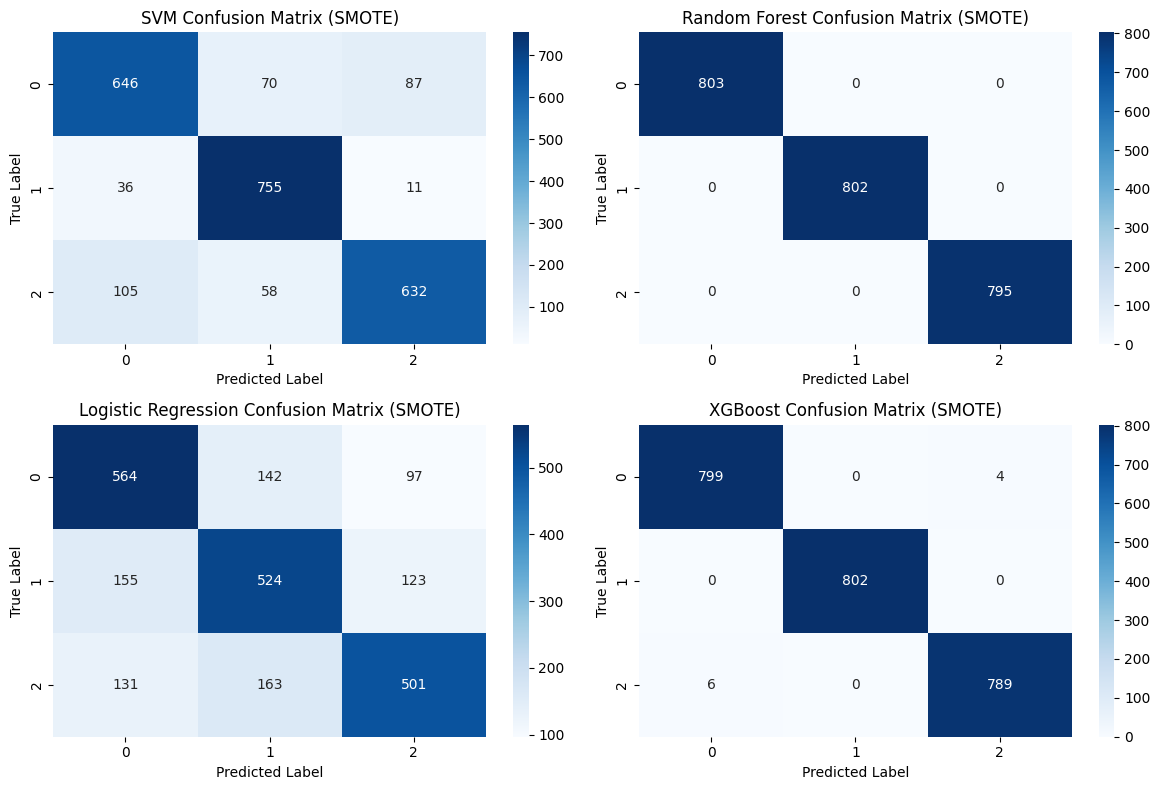

In [ ]:
# Calculate the confusion matrix on the valid data for SMOTE
matrix_val_tree_svm_smote = confusion_matrix(y_val_smote, y_pred_SVM_smote)
matrix_val_tree_rf_smote = confusion_matrix(y_val_smote, y_pred_random_forest_smote)
matrix_val_tree_lr_smote = confusion_matrix(y_val_smote, y_pred_logistic_reg_smote)
matrix_val_tree_XGB_smote = confusion_matrix(y_val_smote, y_pred_XGB_smote)

plot_confusion_matrices(matrix_val_tree_svm_smote, matrix_val_tree_rf_smote, matrix_val_tree_lr_smote, matrix_val_tree_XGB_smote ,"SMOTE")


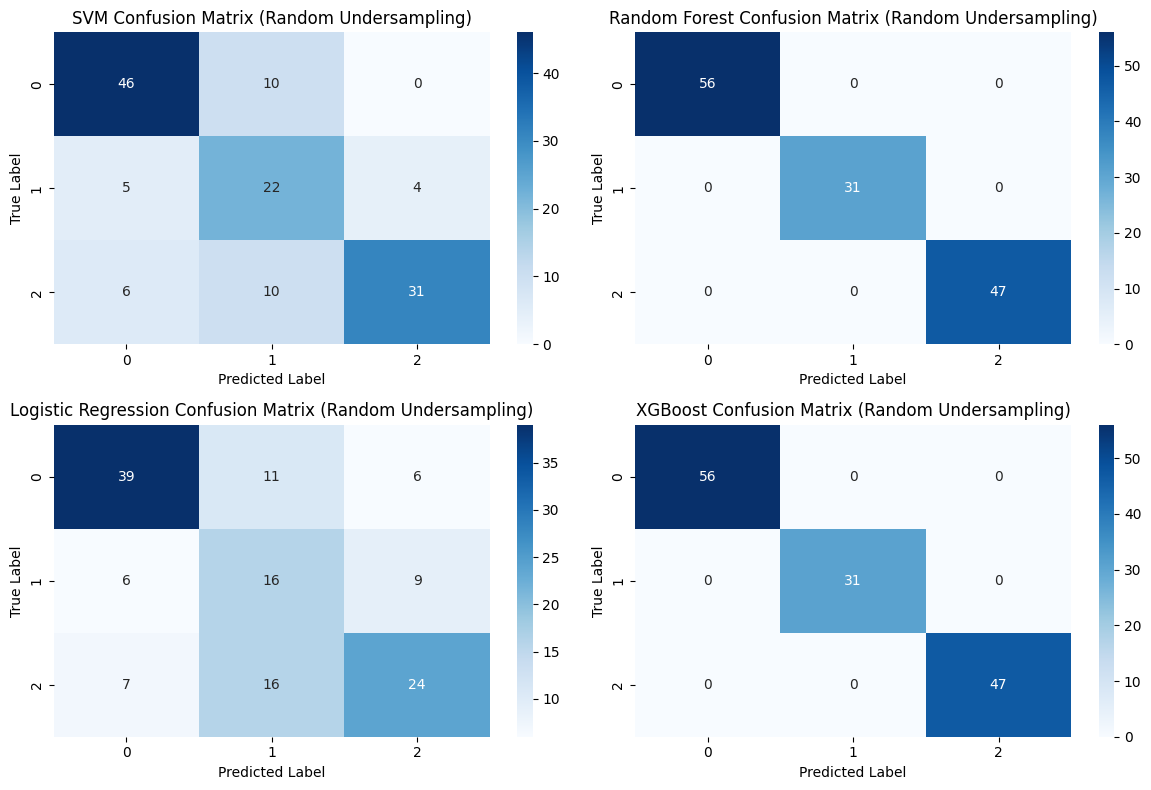

In [ ]:
# Calculate the confusion matrix on the valid data for Random Undersampling
matrix_val_tree_svm_undersample = confusion_matrix(y_val_undersample, y_pred_SVM_undersample)
matrix_val_tree_rf_undersample = confusion_matrix(y_val_undersample, y_pred_random_forest_undersample)
matrix_val_tree_lr_undersample = confusion_matrix(y_val_undersample, y_pred_logistic_reg_undersample)
matrix_val_tree_XGB_undersample = confusion_matrix(y_val_undersample, y_pred_XGB_undersample)

plot_confusion_matrices(matrix_val_tree_svm_undersample, matrix_val_tree_rf_undersample, matrix_val_tree_lr_undersample,matrix_val_tree_XGB_undersample, "Random Undersampling")


## Hyperparameter Optimization

### Fine-Tuning RandomForest and XGBoost Ensemble with Optuna

We're aiming to boost our model's accuracy by combining RandomForest and XGBoost into an ensemble and adjusting their settings with Optuna, a tool for optimizing hyperparameters.

#### How the Ensemble Works

- By mixing the predictions from RandomForest and XGBoost, we can often get a more accurate result than using either model alone. This approach helps smooth out the predictions by using the strengths of both models.

#### Setting Up Optuna

- **Defining What to Optimize:** We set up a function for Optuna that calculates the ensemble model's log loss, which measures prediction accuracy. Optuna tries to find settings that make this log loss as small as possible.
- **Choosing Settings to Try:** In this function, Optuna picks different settings to test for each model, aiming to cover a broad range of possibilities.

#### Running the Optimization

- We ask Optuna to try 100 different sets of settings to see which ones work best.
- **Reviewing Results:** After testing, Optuna tells us which settings had the lowest log loss, meaning they should give us the most accurate predictions.

The aim here is straightforward: adjust our model's settings to improve accuracy as measured by log loss.


In [ ]:
import optuna

# Define a custom scorer for Optuna optimization
def custom_scorer(estimator, X, y):
    y_pred = estimator.predict_proba(X)
    return log_loss(y, y_pred)

# Optimize hyperparameters using Optuna for the ensemble of RandomForest and XGBoost
def optimize_hyperparameters_ensemble(X_train, y_train):
    def objective(trial):
        rf_params = {
            'n_estimators': trial.suggest_int('rf_n_estimators', 50, 1000),
            'max_depth': trial.suggest_int('rf_max_depth', 3, 10),
            'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 10),
            'max_features': trial.suggest_uniform('rf_max_features', 0.1, 1.0),
            'random_state': 42,
            'n_jobs': -1
        }
        
        xgb_params = {
            'n_estimators': trial.suggest_int('xgb_n_estimators', 50, 1000),
            'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 0.001, 0.1),
            'max_depth': trial.suggest_int('xgb_max_depth', 3, 10),
            'subsample': trial.suggest_uniform('xgb_subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_uniform('xgb_colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_loguniform('xgb_gamma', 1e-8, 1.0),
            'reg_alpha': trial.suggest_loguniform('xgb_reg_alpha', 1e-8, 1.0),
            'reg_lambda': trial.suggest_loguniform('xgb_reg_lambda', 1e-8, 1.0),
            'eval_metric': 'mlogloss',
            'objective': 'multi:softprob',
            'num_class': len(np.unique(y_train)),
            'use_label_encoder': False,  # For XGBoost 1.3.0 and later
            'tree_method': 'hist',
            'verbosity': 0
        }
        
        # Initialize RandomForest and XGBoost models with suggested parameters
        rf_model = RandomForestClassifier(**rf_params)
        xgb_model = XGBClassifier(**xgb_params)
        
        # Fit RandomForest and XGBoost models
        rf_model.fit(X_train, y_train)
        xgb_model.fit(X_train, y_train)
        
        # Ensemble the RandomForest and XGBoost models
        ensemble_proba = (rf_model.predict_proba(X_train) + xgb_model.predict_proba(X_train)) / 2
        
        # Calculate log loss for the ensemble on the training set
        ensemble_log_loss = log_loss(y_train, ensemble_proba)

        # Print ensemble log loss for each trial
        print(f"Ensemble Log Loss for trial {trial.number}: {ensemble_log_loss}")
        
        return ensemble_log_loss

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)
    
    best_params = study.best_params
    return best_params

# Optimize hyperparameters for the ensemble of RandomForest and XGBoost
best_params_ensemble = optimize_hyperparameters_ensemble(X_train_resampled_smote, y_train_resampled_smote)
print("Best hyperparameters for Ensemble (RandomForest + XGBoost):", best_params_ensemble)


[I 2024-04-03 17:35:39,189] A new study created in memory with name: no-name-9041f23c-1eaf-4af4-b444-be0352a6f66e
[W 2024-04-03 17:36:21,083] Trial 0 failed with parameters: {'rf_n_estimators': 495, 'rf_max_depth': 10, 'rf_min_samples_split': 19, 'rf_min_samples_leaf': 1, 'rf_max_features': 0.331782746764247, 'xgb_n_estimators': 712, 'xgb_learning_rate': 0.007307341819594112, 'xgb_max_depth': 3, 'xgb_subsample': 0.8196077718107939, 'xgb_colsample_bytree': 0.623674274980203, 'xgb_gamma': 6.116980439680981e-07, 'xgb_reg_alpha': 0.006240930950860085, 'xgb_reg_lambda': 0.0011040222863461897} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/trf1/.local/lib/python3.9/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_2008643/472524088.py", line 45, in objective
    xgb_model.fit(X_train, y_train)
  File "/home/trf1/.local/lib/python3.9/site-packages/xgboost/core.py", l

KeyboardInterrupt: 

## Putting Together the Best-Performing Ensemble Model

We use the top settings found in the optimization step to train RandomForest and XGBoost models.

### Training the Models

- **RandomForest:** With its best settings, this model is trained using data balanced by SMOTE.
- **XGBoost:** This model is also set up with its optimal settings and trained on the same SMOTE-balanced data.

### Making the Ensemble

We combine the strengths of both models by averaging out their predictions. This way, we get the benefits of both models' insights.

### How We Check Its Performance

To see how well our ensemble does, we look at its log loss on data it hasn’t seen before. A smaller log loss number means it’s doing a better job at predicting accurately.

### Analysis

Our ensemble model got a log loss of 0.4838 on the validation data. This shows that combining RandomForest and XGBoost with the right settings can indeed lead to more accurate predictions.

In [ ]:
# Train RandomForest model with best hyperparameters
rf_model = RandomForestClassifier(n_estimators=best_params_ensemble['rf_n_estimators'],
                                   max_depth=best_params_ensemble['rf_max_depth'],
                                   min_samples_split=best_params_ensemble['rf_min_samples_split'],
                                   min_samples_leaf=best_params_ensemble['rf_min_samples_leaf'],
                                   max_features=best_params_ensemble['rf_max_features'],
                                   random_state=42,
                                   n_jobs=-1)
rf_model.fit(X_train_resampled_smote, y_train_resampled_smote)

# Train XGBoost model with best hyperparameters
xgb_model = XGBClassifier(n_estimators=best_params_ensemble['xgb_n_estimators'],
                          learning_rate=best_params_ensemble['xgb_learning_rate'],
                          max_depth=best_params_ensemble['xgb_max_depth'],
                          subsample=best_params_ensemble['xgb_subsample'],
                          colsample_bytree=best_params_ensemble['xgb_colsample_bytree'],
                          gamma=best_params_ensemble['xgb_gamma'],
                          reg_alpha=best_params_ensemble['xgb_reg_alpha'],
                          reg_lambda=best_params_ensemble['xgb_reg_lambda'],
                          eval_metric='mlogloss',
                          objective='multi:softprob',
                          num_class=len(np.unique(y_train_resampled_smote)),
                          use_label_encoder=False,
                          tree_method='hist',
                          verbosity=0)
xgb_model.fit(X_train_resampled_smote, y_train_resampled_smote)

# Create ensemble by averaging predictions
ensemble_proba = (rf_model.predict_proba(X_val_preprocessed) + xgb_model.predict_proba(X_val_preprocessed)) / 2

# Evaluate the ensemble model
ensemble_log_loss = log_loss(y_val_encoded, ensemble_proba)
print("Ensemble Model Validation Log Loss:", ensemble_log_loss)


Ensemble Model Validation Log Loss: 0.4910942913821729


## Preparing Predictions for Submission

Here's how we get our model's predictions ready for a competition submission:

1. **Prepare the Test Data:** We apply the same preprocessing to the test data as we did with the training data, using our established pipeline.

2. **Make Predictions:** The RandomForest and XGBoost models, already trained, predict outcomes for the test data.

3. **Combine Predictions:** We average the predictions from both models to use the strengths of each.

4. **Normalize Predictions:** We adjust the predictions so the probabilities for each prediction sum up to 1.

5. **Format for Submission:** We create a DataFrame with the correct format for submitting to Kaggle, including the IDs from the test data and our predictions.

6. **Save and Submit:** The DataFrame is saved as a CSV file, which can then be submitted to the competition.

We also check the first few rows of our submission to make sure everything looks right before submitting.

In [ ]:
# Prepare the test data 
X_test_preprocessed = full_pipeline_test.transform(X_test)
print("Test data preprocessed.")

# 2. Make predictions on the test data using the trained models
rf_test_proba = rf_model.predict_proba(X_test_preprocessed)
xgb_test_proba = xgb_model.predict_proba(X_test_preprocessed)
print("Predictions made on test data using trained models.")

# 3. Create ensemble predictions by averaging the predictions of the RandomForest and XGBoost models
ensemble_test_proba = (rf_test_proba + xgb_test_proba) / 2

# 4. Rescale the predicted probabilities to ensure they sum up to 1 for each observation
ensemble_test_proba_normalized = ensemble_test_proba / ensemble_test_proba.sum(axis=1, keepdims=True)

# 5. Create a DataFrame containing the submission format
sub = pd.DataFrame({'id': raw_test_data.index}) 
sub[['Status_C', 'Status_CL', 'Status_D']] = ensemble_test_proba_normalized

t2 = pd.read_csv(r"test.csv")
sub['id'] = t2['id']

print("Submission DataFrame created.")
print("First few rows of the submission DataFrame:")
print(sub.head())  # Check the first few rows of the DataFrame

# 6. Save the DataFrame to a CSV file
sub.to_csv('Group20_submission.csv', index=False)
print("Submission CSV file saved.")


Test data preprocessed.
Predictions made on test data using trained models.
Submission DataFrame created.
First few rows of the submission DataFrame:
     id  Status_C  Status_CL  Status_D
0  7905  0.290505   0.050197  0.659297
1  7906  0.735124   0.210660  0.054216
2  7907  0.106133   0.053739  0.840127
3  7908  0.966108   0.010384  0.023508
4  7909  0.694483   0.150751  0.154767
Submission CSV file saved.


# Feature importance

## Understanding What Drives RandomForest and XGBoost Predictions

We’re looking at which features matter most to our RandomForest and XGBoost models. Knowing which features influence predictions the most can guide us in understanding and improving model performance.

### Insights from the Visuals

- **RandomForest**: Important features include 'Bilirubin', 'Age_in_Years', and 'N_Days'. This tells us they're key factors the model considers when predicting.
  
- **XGBoost**: Shows 'Edema_N', 'Hepatomegaly_Y', and 'Bilirubin' as top influencers. These features significantly impact how the model makes decisions.

### Why Feature Importance Matters

- 'Bilirubin' stands out in both models, highlighting its importance in cirrhosis prediction. This insight can be incredibly valuable in a clinical setting, helping to focus on critical health indicators.
- The models value certain features differently, which can inform us about their unique approaches to making predictions.

### Real-World Applications

For healthcare professionals, these insights can prioritize key indicators for diagnosing and managing cirrhosis, potentially leading to better patient outcomes. Understanding which features are most influential helps in making more informed medical decisions.

In [ ]:
# Save the original numeric feature column name
numerical_feature_names = numerical_features

# Gets a new column name for category feature
# 'preprocessor' is fitted as part of the pipeline
# after applying OneHotEncoder, use`.get_feature_names_out`to get the names of all new columns
onehot_columns = full_pipeline_train_smote.named_steps['preprocessor'].named_transformers_['categorical'].get_feature_names_out(categorical_features)

# combine name of numeric and category feature
feature_names = list(numerical_feature_names) + list(onehot_columns)

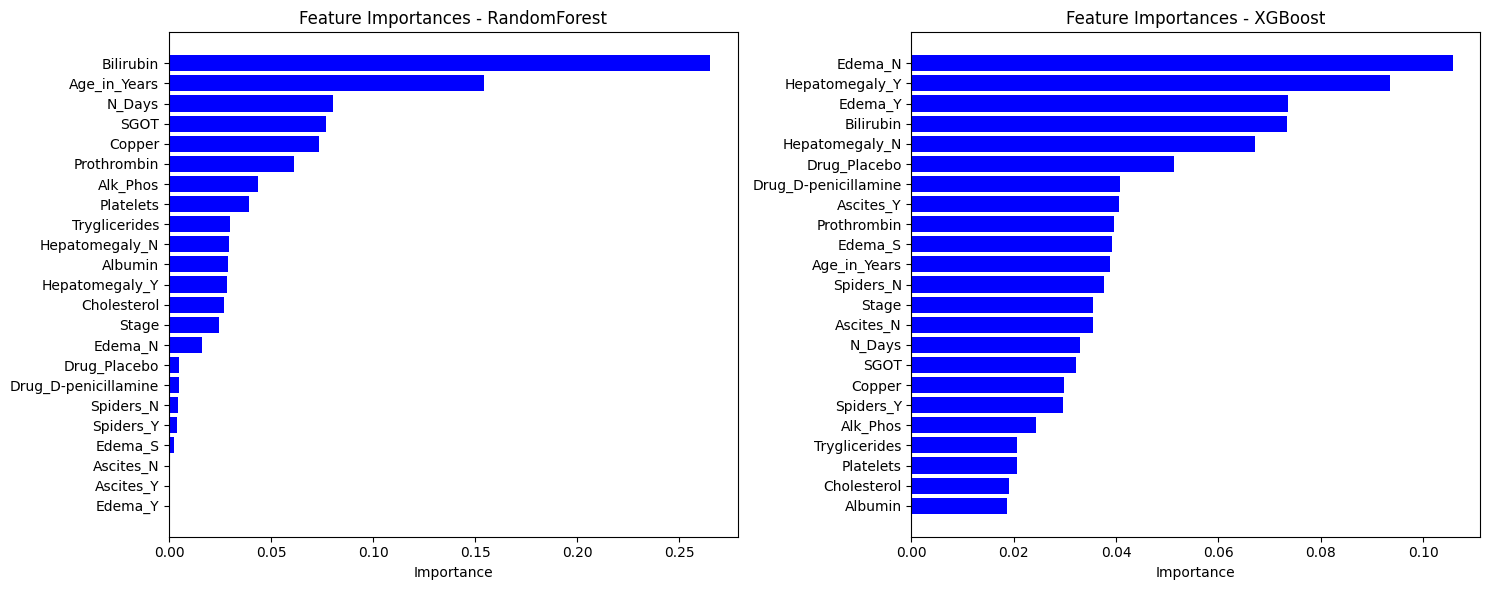

In [ ]:
# random forest feature importance
feature_importances_rf = rf_model.feature_importances_
# sort
sorted_indices_rf = feature_importances_rf.argsort()

# XGB feature importance
feature_importances_xgb = xgb_model.feature_importances_
# sort
sorted_indices_xgb = feature_importances_xgb.argsort()

# Visualize materiality characteristics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# RandomForest
ax1.set_title('Feature Importances - RandomForest')
ax1.barh(range(len(sorted_indices_rf)), feature_importances_rf[sorted_indices_rf], color='b', align='center')
ax1.set_yticks(range(len(sorted_indices_rf)))
ax1.set_yticklabels([feature_names[i] for i in sorted_indices_rf])
ax1.set_xlabel('Importance')

# XGBoost
ax2.set_title('Feature Importances - XGBoost')
ax2.barh(range(len(sorted_indices_xgb)), feature_importances_xgb[sorted_indices_xgb], color='b', align='center')
ax2.set_yticks(range(len(sorted_indices_xgb)))
ax2.set_yticklabels([feature_names[i] for i in sorted_indices_xgb])
ax2.set_xlabel('Importance')

plt.tight_layout()
plt.show()